<a href="https://colab.research.google.com/github/JunhyeongTPark/eeg_vae/blob/main/PD_Multiband_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

Load libraries, set up deterministic algorithms and seed for reproducibility, initialize functions

##Configurations

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [2]:
!pip install pytictoc

In [3]:
from pytictoc import TicToc

import numpy as np
import pandas as pd
import os
import time
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import runtime, drive
from torch.utils.checkpoint import checkpoint

In [4]:
if torch.cuda.is_available():
    print("GPU is available and being used.")
else:
    print("GPU is not available or not being used.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is available and being used.


In [5]:
print("Mounting Google Drive at /content/drive")
drive.mount('/content/drive')

Mounting Google Drive at /content/drive
Mounted at /content/drive


In [6]:
def seed_everything(seed=42):
    # Set seed for RNGs
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Use deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

SEED = 42
seed_everything(SEED)

In [7]:
# To gauge training/fine-tuning duration
t = TicToc()

##Load Data

In [8]:
processed_data = torch.load('/content/drive/MyDrive/Colab_Notebooks/processed_data_cz.pt')

In [9]:
train_signals = processed_data['train_signals']
train_labels = processed_data['train_labels']
val_signals = processed_data['val_signals']
val_labels = processed_data['val_labels']
test_signals = processed_data['test_signals']
test_labels = processed_data['test_labels']

In [10]:
# Verifying class proportions
trl, train_counts = torch.unique(train_labels, return_counts=True)
val_trl, val_counts = torch.unique(val_labels, return_counts=True)
test_trl, test_counts = torch.unique(test_labels, return_counts=True)

print(train_counts / len(train_labels))
print(val_counts / len(val_labels))
print(test_counts / len(test_labels))

tensor([0.3269, 0.3240, 0.2204, 0.1287])
tensor([0.3264, 0.3243, 0.2203, 0.1290])
tensor([0.3273, 0.3235, 0.2204, 0.1289])


In [11]:
train_signals.shape

torch.Size([17349, 4, 1, 251])

##Dataset & DataLoader

In [12]:
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
def seed_worker(worker_id):
    # Seed dataloader workers for reproducibility
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_loader = torch.Generator()
g_loader.manual_seed(SEED)

In [14]:
train_data = EEGDataset(train_signals, train_labels)
val_data = EEGDataset(val_signals, val_labels)
test_data = EEGDataset(test_signals, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g_loader)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True,
    num_workers=4,pin_memory=True, worker_init_fn=seed_worker, generator=g_loader)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g_loader)

##Beta Anealing

In [15]:
def sigmoid_anneal(epoch, midpoint=10, scale=1.0):
    return float(1 / (1 + torch.exp(torch.tensor(-(epoch - midpoint)))) * scale)

def linear_warmup(epoch, max_beta=1.0, warmup_epochs=20):
    return min(max_beta, max_beta * epoch / warmup_epochs)

##Save & Load Model Checkpoint Functions

In [27]:
# Save model checkpoint locally and to Google Drive
def save_model(epoch, model, optimizer, scheduler, train_losses, val_losses, hparams):
    # Define path
    file_name = f'Model_E{epoch}.pth'
    path = f'/content/drive/My Drive/Colab_Notebooks/Saved Models/{file_name}'

    # Save the checkpoint locally
    print(f'\n--- Saving checkpoint for epoch {epoch} to {path} ---')
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'hyperparameters': hparams
    }
    torch.save(checkpoint_dict, path)

In [18]:
def load_model(BANDS, model_hparams, checkpoint_name, folder='SM'):
    multiband_model = MultiBandVae(hparams=model_hparams, num_bands=len(BANDS)).to(device)

    if folder == 'TM':
        folder_name = '/content/drive/My Drive/Colab_Notebooks/Saved Models/Transformer Models/'
    elif folder == 'FT':
        folder_name = '/content/drive/My Drive/Colab_Notebooks/Saved Models/Fine Tuning/'
    elif folder == 'FC':
        folder_name = "/content/drive/My Drive/Colab_Notebooks/Saved Models/Final Candidates/"
    else:
        folder_name = '/content/drive/My Drive/Colab_Notebooks/Saved Models/'
    filename = checkpoint_name + '.pth'

    PATH = os.path.join(folder_name, filename)

    if os.path.exists(PATH):
        print(f'Loading model checkpoint from {PATH}')

        checkpoint = torch.load(PATH, map_location=device)
        multiband_model.load_state_dict(checkpoint['model_state_dict'])
        last_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        # checkpoint_hparams = checkpoint.get('hyperparameters', None)

        print(f'Loaded checkpoint from epoch {last_epoch}')
        return multiband_model, last_epoch, train_losses, val_losses #, checkpoint_hparams
    else:
        print(f'File not found at {PATH} - Check your folder name')
        return None, None, None, None

##Diagnostic Functions

In [19]:
# Plot training and validation loss
def plot_losses(train_losses, val_losses):
    # Extract losses
    train_total = [t[0] for t in train_losses]
    train_recon = [t[1] for t in train_losses]
    train_kl    = [t[2] for t in train_losses]

    val_total = [v[0] for v in val_losses]
    val_recon = [v[1] for v in val_losses]
    val_kl    = [v[2] for v in val_losses]

    loss_names = ['Total', 'Recon', 'KL']
    train_data = [train_total, train_recon, train_kl]
    val_data   = [val_total, val_recon, val_kl]

    # Plot
    plt.figure(figsize=(15, 8))

    for i, (name, train_vals, val_vals) in enumerate(zip(loss_names, train_data, val_data), 1):
        plt.subplot(2, 3, i)
        plt.plot(train_vals, label=f'Train {name}')
        plt.plot(val_vals, label=f'Val {name}')
        plt.title(f'{name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [20]:
# Plot a sample reconstruction
def plot_reconstruction(model, data_loader, num_bands=4, channel_to_plot=0):
    model.eval()

    with torch.no_grad():
        x, _ = next(iter(data_loader))

        sample = x[0].unsqueeze(0).to(device)
        recon, _, _ = model(sample)

    original_fbs = sample.cpu().numpy().squeeze(0)
    recon_fbs = recon.cpu().numpy().squeeze(0)

    fig, axes = plt.subplots(num_bands + 1, 1, figsize=(15,12), sharex=True)
    fig.suptitle(f'Generated Samples {channel_to_plot}', fontsize=16)

    band_names = ['Delta', 'Theta', 'Alpha', 'Beta']

    for i in range(num_bands):
        ax = axes[i]
        ax.plot(original_fbs[i, channel_to_plot, :], label='Original', color='blue', alpha=0.8)
        ax.plot(recon_fbs[i, channel_to_plot, :], label='Reconstruction', color='red', alpha=0.8)
        ax.set_title(f'{band_names[i]} Band')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    original_combined = original_fbs.sum(axis=0)
    recon_combined = recon_fbs.sum(axis=0)

    ax_combined = axes[-1]
    ax_combined.plot(original_combined[channel_to_plot, :], label='Original', color='blue', alpha=0.8)
    ax_combined.plot(recon_combined[channel_to_plot, :], label='Reconstruction', color='red', alpha=0.8)
    ax_combined.set_title('Combined Signal: Original vs Reconstructed')
    ax_combined.set_ylabel('Amplitude')
    plt.grid(True, linestyle='--', alpha=0.6)
    axes[-1].set_xlabel('Timepoints (250hz)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [21]:
# Plot sample generation from VAE
def plot_generation(model, num_samples=1, num_bands=4, temperature=1.0, channel_to_plot=0):
    model.eval()

    with torch.no_grad():
        generated_bands = model.generate(n_samples=num_samples)

    generated_sample = generated_bands.cpu().numpy().squeeze(0)

    band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Combined']

    fig, axes = plt.subplots(num_bands + 1, 1, figsize=(15,12), sharex=True)
    fig.suptitle(f'Generated Samples {channel_to_plot}', fontsize=16)

    for i in range(num_bands):
        ax = axes[i]
        ax.plot(generated_sample[i, channel_to_plot, :], label='Generation', color='blue', alpha=0.8)
        ax.set_title(f'{band_names[i]} Band')
        ax.set_ylabel('Amplitude')
        ax.grid(True, linestyle='--', alpha=0.6)

    combined_generation = generated_sample.sum(axis=0)

    ax_combined = axes[-1]
    ax_combined.plot(combined_generation[channel_to_plot, :], label='Combined Signal', color='red', alpha=0.8)
    ax_combined.set_title('Combined Signal')
    ax_combined.set_ylabel('Amplitude')
    plt.grid(True, linestyle='--', alpha=0.6)
    axes[-1].set_xlabel('Timepoints (250hz)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


##VAE Loss Functions

In [22]:
def vae_loss_weighted_mae(x, x_recon_stack, mus, logvars, beta, weights, kl_mean=True):
    # x and x_recon_stack have shape [B, F, C, T]
    # weights is a list or tensor of length F, e.g., [1.0, 1.0, 1.5, 2.0]

    num_bands = x.shape[1]
    recon_losses = []

    for i in range(num_bands):
        # Calculate the MAE for the current band
        band_mae = torch.abs(x_recon_stack[:, i] - x[:, i]).mean()

        # Apply the specific weight for this band
        weighted_loss = weights[i] * band_mae
        recon_losses.append(weighted_loss)

    total_recon_loss = torch.stack(recon_losses).sum()

    kl_divs = []
    for mu, logvar in zip(mus, logvars):
        kl_div = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)).mean()
        kl_divs.append(kl_div)

    if kl_mean:
        kl_loss = torch.stack(kl_divs).mean()
    else:
        kl_loss = torch.stack(kl_divs).sum()

    loss = total_recon_loss + beta * kl_loss
    return loss, total_recon_loss, kl_loss

##Training/Fine Tuning Function

The function stores the best model while training/fine-tuning (lowest reconstruction or kl) so it can be saved along with the model being saved on the last epoch.

In [23]:
def train_vae(model, train_loader, val_loader, epochs, lr, max_beta,
                          band_weights, beta_annealing=False, minimize='recon', start_epoch=0,
                          lr_warmup=False, warmup_epochs=20, initial_lr=1e-7, device='cuda',
                          kl_loss_threshold=None, recon_loss_threshold=None, weight_decay=0):

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    scaler = torch.amp.GradScaler('cuda')

    best_recon_val_loss = float('inf')
    best_kl_val_loss = float('inf')
    best_checkpoint = None
    epochs_no_improve = 0
    patience = 50

    t.tic()

    for epoch in range(start_epoch, epochs):
        if beta_annealing:
            beta = max_beta * sigmoid_anneal(epoch, midpoint=200, scale=0.1)
        else:
            beta = max_beta

        if lr_warmup and epoch < warmup_epochs:
            current_lr = initial_lr + (lr - initial_lr) * (epoch / warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr

        # Training Phase
        model.train()
        total_train_loss, total_train_recon, total_train_kl = 0.0, 0.0, 0.0

        for x, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Train]'):
            x, labels = x.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                recon_combined, mus, logvars = model(x)

                loss, recon_loss, kl_loss = vae_loss_weighted_mae(
                    x, recon_combined, mus, logvars, beta, band_weights
                )

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()
            total_train_recon += recon_loss.item()
            total_train_kl += kl_loss.item()

        # Log average training losses
        num_batches_train = len(train_loader)
        avg_train = tuple(v / num_batches_train for v in [total_train_loss, total_train_recon, total_train_kl])
        train_losses.append(avg_train)

        # Validation Phase
        model.eval()
        total_val_loss, total_val_recon, total_val_kl = 0.0, 0.0, 0.0
        with torch.no_grad():
            for x, labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{epochs} [Val]'):
                x, labels = x.to(device), labels.to(device)

                with torch.amp.autocast('cuda'):
                    recon_combined, mus, logvars = model(x)

                    loss, recon_loss, kl_loss = vae_loss_weighted_mae(
                        x, recon_combined, mus, logvars, beta, band_weights
                    )

                total_val_loss += loss.item()
                total_val_recon += recon_loss.item()
                total_val_kl += kl_loss.item()

            # Log average training losses
            num_batches_val = len(val_loader)
            avg_val = tuple(v / num_batches_val for v in [total_val_loss, total_val_recon, total_val_kl])
            val_losses.append(avg_val)

        # Update Scheduler
        if not lr_warmup or (lr_warmup and epoch >= warmup_epochs):
            scheduler.step(avg_val[0])

        # Logging and Saving Logic
        print(f'\nEpoch {epoch+1} - Beta={beta:.4f}')
        print(f'Train - Avg Total: {avg_train[0]:.4f}, Avg Recon: {avg_train[1]:.4f}, Avg KL: {avg_train[2]:.4f}')
        print(f'Val   - Avg Total: {avg_val[0]:.4f}, Avg Recon: {avg_val[1]:.4f}, Avg KL: {avg_val[2]:.4f}\n')

        current_recon_val_loss = avg_val[1]
        current_kl_val_loss = avg_val[2]

        if minimize == 'recon':
            if kl_loss_threshold != None and current_kl_val_loss > kl_loss_threshold:
                print(f'\nEarly stopping triggered: Kl loss ({current_kl_val_loss:.4f}) exceeded threshold.')
                break

            # Store the best reconstruction checkpoint in memory
            if current_recon_val_loss < best_recon_val_loss:
                best_recon_val_loss = current_recon_val_loss
                print(f'New best validation reconstruction loss: {best_recon_val_loss:.4f}. Storing checkpoint.')
                best_checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': multiband_model.state_dict().copy(),
                    'optimizer_state_dict': optimizer.state_dict().copy(),
                    'scheduler_state_dict': scheduler.state_dict().copy(),
                    'train_losses': train_losses.copy(),
                    'val_losses': val_losses.copy(),
                    'hyperparameters': model_hparams
                }

                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                print(f'Validation reconstruction loss did not improve. Patience: {epochs_no_improve}/{patience}')
        else:
            if recon_loss_threshold != None and current_recon_val_loss > recon_loss_threshold:
                print(f'\nEarly stopping triggered: Reconstruction loss ({current_recon_val_loss:.4f}) exceeded threshold.')
                break

            # Store the best kl checkpoint in memory
            if current_kl_val_loss < best_kl_val_loss:
                best_kl_val_loss = current_kl_val_loss
                print(f'New best validation kl loss: {best_kl_val_loss:.4f}. Storing checkpoint.')
                best_checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': multiband_model.state_dict().copy(),
                    'optimizer_state_dict': optimizer.state_dict().copy(),
                    'scheduler_state_dict': scheduler.state_dict().copy(),
                    'train_losses': train_losses.copy(),
                    'val_losses': val_losses.copy(),
                    'hyperparameters': model_hparams
                }

                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                print(f'Validation kl loss did not improve. Patience: {epochs_no_improve}/{patience}')

        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs.')
            break

        # Save a checkpoint every 50 epochs
        if (epoch + 1) % 50 == 0:
            print('Saving model checkpoint...')
            save_model(epoch + 1, multiband_model, optimizer, scheduler, train_losses, val_losses, model_hparams)


    print(f'\nTraining finished at epoch {epoch + 1}.')

    t.toc('Training Duration:')

    # Save model at end of training
    print('Saving final model (best for generation)...')
    save_model(epoch + 1, multiband_model, optimizer, scheduler, train_losses, val_losses, model_hparams)

    # Save the best model in terms of reconstruction or kl loss
    if best_checkpoint:
        best_epoch_num = best_checkpoint['epoch']
        print(f'Saving best reconstruction model from epoch {best_epoch_num}...')

        hparams_to_save = best_checkpoint['hyperparameters']
        model_to_save = MultiBandVae(hparams=model_hparams, num_bands=len(BANDS)).to(device)
        optimizer_to_save = torch.optim.Adam(model_to_save.parameters())
        scheduler_to_save = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_to_save)

        model_to_save.load_state_dict(best_checkpoint['model_state_dict'])
        optimizer_to_save.load_state_dict(best_checkpoint['optimizer_state_dict'])
        scheduler_to_save.load_state_dict(best_checkpoint['scheduler_state_dict'])

        save_model(
            epoch=best_epoch_num,
            model=model_to_save,
            optimizer=optimizer_to_save,
            scheduler=scheduler_to_save,
            train_losses=best_checkpoint['train_losses'],
            val_losses=best_checkpoint['val_losses'],
            hparams=hparams_to_save
        )
    else:
        print('No best model was saved.')

    print("\nAll saving complete.")


#Unimodal Model Analysis

##Transformer VAE

###Model

Transformer-based VAE model

VAE architecture was designed with four separate encoder/decoder pairs to dedicate a portion of the latent variables to each frequency band. Hypothesized that grouping of variables could lead to insights regarding the importance of each frequency band (lby using the sparse group lasso model or another grouping model).

**Future models will test both architectures with separate encoders/decoders or a single encoder/decoder pair (emphasizing frequency band interactions).**

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=251):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation='gelu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.gelu if activation == 'gelu' else F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        x = src
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=src_mask)
        x = x + self.dropout1(attn_output)

        x_res = x
        x_norm = self.norm2(x_res)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x_norm))))
        x = x_res + self.dropout2(ff_output)
        return x

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation='gelu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self. activation = F.gelu if activation == 'gelu' else F.relu

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        x = tgt
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=tgt_mask)
        x = x + self.dropout1(attn_output)

        x_res = x
        x_norm = self.norm2(x_res)
        attn_output, _ = self.multihead_attn(x_norm, memory, memory)
        x = x_res + self.dropout2(attn_output)

        x_res = x
        x_norm = self.norm3(x_res)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x_norm))))
        x = x_res + self.dropout3(ff_output)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, num_electrodes=8, seq_len=251, d_model=128, nhead=8, num_layers=3, latent_dim=64, dropout=0.2, device='cuda'):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        self.mask = nn.Transformer.generate_square_subsequent_mask(self.seq_len).to(device)

        self.conv_stem = nn.Sequential(
            # [B, C, T] --> [B, d_model, T]
            nn.Conv1d(in_channels=num_electrodes, out_channels=d_model // 4, kernel_size=7, padding=3),
            nn.BatchNorm1d(d_model // 4),
            nn.GELU(),
            nn.Conv1d(in_channels=d_model // 4, out_channels=d_model // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model // 2),
            nn.GELU(),
            nn.Conv1d(in_channels=d_model // 2, out_channels=d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model),
            nn.GELU()
        )

        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, d_model*4, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)

    def forward(self, x):
        x = self.conv_stem(x)

        # x shape: [B, C, T] -> permute to [B, T, C]
        x = x.permute(0, 2, 1)

        # Embed input and add positional encoding
        x = self.pos_encoder(x)

        # Pass through Transformer encoder
        for layer in self.layers:
            x = layer(x, src_mask=self.mask)
        x = self.norm(x)

        # Use last time step
        sequence_embedding = x[:, -1, :]
        mu = self.fc_mu(sequence_embedding)
        logvar = self.fc_logvar(sequence_embedding)

        return mu, logvar

class TransformerDecoder(nn.Module):
    def __init__(self, num_electrodes=8, seq_len=251, d_model=128, nhead=8, num_layers=3, latent_dim=64, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        # Project Latent Vector to Sequence
        self.latent_to_seq = nn.Linear(latent_dim, d_model)

        # Create a "Query" sequence for the decoder
        self.decoder_query = nn.Parameter(torch.randn(1, seq_len, d_model))

        # Transformer Decoder
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, nhead, d_model*4, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

        # Output Projection
        self.fc_out = nn.Linear(d_model, num_electrodes)

    def forward(self, z):
        batch_size = z.size(0)

        memory = self.latent_to_seq(z).unsqueeze(1)
        tgt = self.decoder_query.repeat(batch_size, 1, 1)

        for layer in self.layers:
            tgt = layer(tgt, memory)
        output = self.norm(tgt)

        output = self.fc_out(output)

        return output.permute(0, 2, 1)

class MultiBandVae(nn.Module):
    def __init__(self, num_bands=4,
                 hparams = {
                      'num_electrodes': 1,
                      'seq_len': 251,
                      'd_model': 256,
                      'nhead': 8,
                      'num_layers': 3,
                      'latent_dim': 32,
                      'dropout': 0.2
                  }
        ):
        super().__init__()
        self.num_bands = num_bands
        self.latent_dim = hparams['latent_dim']

        base_hparams = hparams.copy()

        alpha_hparams = hparams.copy()
        alpha_hparams.update({
            'd_model': 512,
            'nhead': 16,
            'num_layers': 3,
            'latent_dim': int(self.latent_dim * 1.5)
        })

        beta_hparams = hparams.copy()
        beta_hparams.update({
            'd_model': 768,
            'nhead': 16,
            'num_layers': 4,
            'latent_dim': int(self.latent_dim * 2)
        })

        all_hparams = [base_hparams, base_hparams, alpha_hparams, beta_hparams]

        self.encoders = nn.ModuleList([
            TransformerEncoder(**base_hparams),
            TransformerEncoder(**base_hparams),
            TransformerEncoder(**alpha_hparams),
            TransformerEncoder(**beta_hparams)
        ])

        self.decoders = nn.ModuleList([
            TransformerDecoder(**base_hparams),
            TransformerDecoder(**base_hparams),
            TransformerDecoder(**alpha_hparams),
            TransformerDecoder(**beta_hparams)
        ])

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        mus, logvars, zs = [], [], []

        for i in range(self.num_bands):
            band_x = x[:, i, :, :]

            mu, logvar = self.encoders[i](band_x)

            mus.append(mu)
            logvars.append(logvar)

            z = self.reparameterize(mu, logvar)

            zs.append(z)

        return mus, logvars, zs

    def decode(self, zs):
        recon_bands = []
        for i in range(self.num_bands):
            recon_band = self.decoders[i](zs[i])
            recon_bands.append(recon_band)

        return torch.stack(recon_bands, dim=1)

    def forward(self, x):
        mus, logvars, zs = self.encode(x)
        recon_combined = self.decode(zs)

        return recon_combined, mus, logvars

    def generate(self, n_samples=1, temperature=1.0, device='cuda'):
        self.eval()

        zs = []
        for i in range(self.num_bands):
            latent_dim = self.encoders[i].fc_mu.out_features
            zs.append(torch.randn(n_samples, latent_dim, device=device) * temperature)

        with torch.no_grad():
            return self.decode(zs)

### Model Parameters

In [25]:
BANDS = ['delta', 'theta', 'alpha', 'beta']
model_hparams = {
    'num_electrodes': 1,
    'seq_len': 251,
    'd_model': 256,
    'nhead': 8,
    'num_layers': 3,
    'latent_dim': 32,
    'dropout': 0.2
}

###Training

In [28]:
multiband_model = MultiBandVae(hparams=model_hparams, num_bands=len(BANDS)).to(device)

for i in range(len(multiband_model.decoders)):
    multiband_model.decoders[i].fc_out.weight.data.uniform_(-0.001, 0.001)
    multiband_model.decoders[i].fc_out.bias.data.fill_(0)

epochs = 500
max_beta = 0.01
lr = 1e-4
band_weights = torch.tensor([1.0, 1.5, 2.75, 5.5], device=device)

train_losses, val_losses = [], []

train_vae(
    model=multiband_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr = lr,
    max_beta=max_beta,
    band_weights=band_weights,
    lr_warmup=True,
    beta_annealing=True,
    minimize='recon',
    start_epoch=0,
    device=device
  )

Epoch 1/1 [Val]: 100%|██████████| 272/272 [00:14<00:00, 19.40it/s]



Epoch 1 - Beta=0.0000
Train - Avg Total: 8.3255, Avg Recon: 8.3255, Avg KL: 4.8694
Val   - Avg Total: 8.3298, Avg Recon: 8.3298, Avg KL: 4.7140

New best validation reconstruction loss: 8.3298. Storing checkpoint.

Training finished at epoch 1.
Training Duration: 102.092389 seconds.
Saving final model (best for generation)...

--- Saving checkpoint for epoch 1 to /content/drive/My Drive/Colab_Notebooks/Saved Models/Model_E1.pth ---
Saving best reconstruction model from epoch 1...

--- Saving checkpoint for epoch 1 to /content/drive/My Drive/Colab_Notebooks/Saved Models/Model_E1.pth ---

All saving complete.


In [ ]:
runtime.unassign()

###Fine Tuning KL

In [23]:
# Load Model
multiband_model, last_epoch, train_losses, val_losses = load_model(BANDS, model_hparams, 'Model_E313')

Loading model checkpoint from /content/drive/My Drive/Colab_Notebooks/Saved Models/Transformer Models/Model_E313.pth
Loaded checkpoint from epoch 313


In [24]:
# Continue Training

epochs = 600
max_beta = 0.1
lr = 1e-7
band_weights = torch.tensor([1.0, 1.5, 2.75, 5.5], device=device)


train_vae(
    model=multiband_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr = lr,
    max_beta=max_beta,
    band_weights=band_weights,
    minimize='kl',
    recon_loss_threshold=2.5,
    start_epoch=last_epoch,
    device=device
  )

Epoch 314/600 [Train]:  13%|█▎        | 71/543 [00:18<02:01,  3.88it/s]


KeyboardInterrupt: 

In [ ]:
runtime.unassign()

###Fine Tuning Recon

In [ ]:
# Load Model
multiband_model, last_epoch, train_losses, val_losses = load_model(BANDS, model_hparams, 'Model_E414', 'FT')

In [ ]:
epochs = 700
max_beta = 0.001
lr = 1e-6
band_weights = torch.tensor([1.0, 1.5, 2.75, 5.5], device=device)

train_vae(
    model=multiband_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr = lr,
    max_beta=max_beta,
    band_weights=band_weights,
    minimize='recon',
    kl_loss_threshold=120.0,
    start_epoch=last_epoch,
    device=device
  )

In [ ]:
runtime.unassign()

###Diagnostics

In [26]:
plot_losses(train_losses, val_losses)

NameError: name 'plot_losses' is not defined

In [ ]:
plot_reconstruction(multiband_model, val_loader)

In [ ]:
plot_generation(multiband_model)

##CNN-RNN VAE

Note: Testing alternative model architectures based on CNNs and RNNs. Currently underperforms in comparison to the Transformer-based VAE above.

###Model V1

In [ ]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.2):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.dropout = nn.Dropout(dropout)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.dropout(out)

        out += residual
        return out

class CNNEncoder(nn.Module):
    def __init__(self, num_electrodes, base_channels=64, num_layers=4, latent_dim=32, dropout=0.2):
        super().__init__()
        self.in_channels = base_channels

        self.conv1 = nn.Conv1d(num_electrodes, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            stride = 2 if i < 2 else 1
            out_channels = self.in_channels * 2 if i < 2 else self.in_channels
            self.layers.append(ResidualBlock1D(self.in_channels, out_channels, stride, dropout=dropout))
            if i < 2:
              self.in_channels = out_channels

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc_mu = nn.Linear(self.in_channels, latent_dim)
        self.fc_logvar = nn.Linear(self.in_channels, latent_dim)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        for layer in self.layers:
            out = layer(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        logvar = torch.clamp(logvar, max=10)
        return mu, logvar

class CNNDecoder(nn.Module):
    def __init__(self, num_electrodes=1, base_channels=64, num_layers=4, latent_dim=32, seq_len=251, dropout=0.2):
        super().__init__()
        num_downsampling = 2
        # Calculate the starting channel size from the encoder's end state
        self.in_channels = base_channels * (2**num_downsampling)
        self.initial_seq_len = seq_len // (2**(num_downsampling + 1)) # +1 for the initial conv

        # Initial projection from latent space
        self.initial_seq_len = seq_len // 4
        self.fc = nn.Linear(latent_dim, self.in_channels * self.initial_seq_len)

        # Upsampling
        self.layers = nn.ModuleList()
        for i in range(num_downsampling):
            self.layers.append(ResidualBlock1D(self.in_channels, self.in_channels, dropout=dropout))
            self.layers.append(nn.ConvTranspose1d(self.in_channels, self.in_channels // 2, kernel_size=4, stride=2, padding=1))
            self.in_channels //= 2

        # Final residual blocks to match the encoder's depth
        for i in range(num_layers - num_downsampling):
            self.layers.append(ResidualBlock1D(self.in_channels, self.in_channels, dropout=dropout))

        self.dropout = nn.Dropout(dropout)

        # Final upsampling layer and projection
        self.final_upsample = nn.ConvTranspose1d(self.in_channels, self.in_channels, kernel_size=4, stride=2, padding=1)
        self.final_conv = nn.Conv1d(self.in_channels, num_electrodes, kernel_size=7, stride=1, padding=3)

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), -1, self.initial_seq_len)

        for layer in self.layers:
            out = layer(out)
            if isinstance(layer, nn.ConvTranspose1d):
                out = F.relu(out)

        out = F.relu(self.final_upsample(out))
        out = self.dropout(out)

        out = self.final_conv(out)
        target_len = 251
        out = F.pad(out, (0, target_len - out.size(2)))

        return out

class MultiBandVae(nn.Module):
    def __init__(self, num_bands=4, hparams={}):
        super().__init__()
        self.num_bands = num_bands

        self.latent_dim = hparams.get('latent_dim', 32)
        base_hparams = hparams.copy()

        alpha_hparams = hparams.copy()
        alpha_hparams.update({
            'base_channels': 96,
            'num_layers': 5,
            'latent_dim': int(self.latent_dim * 1.5)
        })

        beta_hparams = hparams.copy()
        beta_hparams.update({
            'base_channels': 128,
            'num_layers': 6,
            'latent_dim': int(self.latent_dim * 2.0)
        })

        all_hparams = [base_hparams, base_hparams, alpha_hparams, beta_hparams]

        encoder_hparams_list = [
            {key: val for key, val in hp.items() if key != 'seq_len'}
            for hp in all_hparams
        ]

        self.encoders = nn.ModuleList([CNNEncoder(**hp) for hp in encoder_hparams_list])
        self.decoders = nn.ModuleList([CNNDecoder(**hp) for hp in all_hparams])

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        mus, logvars = [], []
        for i in range(self.num_bands):
            mu, logvar = self.encoders[i](x[:, i])
            mus.append(mu)
            logvars.append(logvar)
        return mus, logvars

    def decode(self, zs):
        recon_bands = []
        for i, z in enumerate(zs):
            recon_band = self.decoders[i](z)
            recon_bands.append(recon_band.unsqueeze(1))
        return torch.cat(recon_bands, dim=1)

    def forward(self, x):
        mus, logvars = self.encode(x)
        zs = [self.reparameterize(mu, logvar) for mu, logvar in zip(mus, logvars)]
        recon_combined = self.decode(zs)
        return recon_combined, mus, logvars

    def generate(self, n_samples=1, device='cuda'):
        self.eval()

        zs = []
        for i in range(self.num_bands):
            latent_dim = self.encoders[i].fc_mu.out_features
            zs.append(torch.randn(n_samples, latent_dim, device=device))

        with torch.no_grad():
            return self.decode(zs)

###Model V2

In [ ]:
class Conv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        total_p = kernel_size + (kernel_size - 1) * (dilation - 1) - 1
        left_p = total_p // 2
        right_p = total_p - left_p

        self.conv = nn.Sequential(
            nn.ConstantPad1d((left_p, right_p), 0),
            nn.Conv1d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=kernel_size, stride=stride, dilation=dilation, bias=bias
            )
        )

    def forward(self, x):
        return self.conv(x)

class FConv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        p = (dilation * (kernel_size - 1)) // 2
        op = stride - 1
        self.fconv = nn.ConvTranspose1d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=stride,
            padding=p, output_padding=op,
            dilation=dilation, bias=bias
        )

    def forward(self, x):
        return self.fconv(x)

class HeadLayer(nn.Module):
    def __init__(self, in_channels, out_channels, negative_slope=0.2):
        super().__init__()

        unit = out_channels // 4

        self.conv1 = nn.Sequential(
            Conv1dLayer(in_channels, unit, kernel_size=11, stride=1),
            nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope)
        )
        self.conv2 = nn.Sequential(
            Conv1dLayer(in_channels, unit, kernel_size=9, stride=1),
            nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope)
        )
        self.conv3 = nn.Sequential(
            Conv1dLayer(in_channels, unit, kernel_size=7, stride=1),
            nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope)
        )
        self.conv4 = nn.Sequential(
            Conv1dLayer(in_channels, unit, kernel_size=5, stride=1),
            nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope)
        )
        self.conv5 = nn.Sequential(
            Conv1dLayer(out_channels, out_channels, kernel_size=3, stride=2),
            nn.BatchNorm1d(out_channels), nn.LeakyReLU(negative_slope)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        out = torch.cat([x1, x2, x3, x4], dim=1)
        out = self.conv5(out)
        return out

class ResBlockV1(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, negative_slope=0.2):
        super().__init__()
        if stride == 1 and in_channels == out_channels:
            self.projection = None
        else:
            self.projection = nn.Sequential(
                Conv1dLayer(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        self.conv1 = nn.Sequential(
            Conv1dLayer(in_channels, out_channels, kernel_size, stride, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(negative_slope)
        )
        self.conv2 = nn.Sequential(
            Conv1dLayer(out_channels, out_channels, kernel_size, 1, bias=False),
            nn.BatchNorm1d(out_channels)
        )
        self.act = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        res = self.projection(x) if self.projection else x
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + res
        out = self.act(out)
        return out

class CNNEncoderV2(nn.Module):
    def __init__(self, num_electrodes, base_channels=16, num_layers=4, latent_dim=32, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([HeadLayer(in_channels=num_electrodes, out_channels=base_channels)])

        in_chan = base_channels
        for i in range(num_layers):
            out_chan = in_chan * 2
            self.layers.append(ResBlockV1(in_chan, out_chan, kernel_size=3, stride=2))
            in_chan = out_chan

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.final_fc = nn.Linear(in_chan, latent_dim * 2)
        self.mu = nn.Linear(latent_dim * 2, latent_dim)
        self.log_var = nn.Linear(latent_dim * 2, latent_dim)

    def forward(self, x):
        for m in self.layers:
            x = m(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.final_fc(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

class CNNDecoderV2(nn.Module):
    def __init__(self, num_electrodes=1, base_channels=16, num_layers=4, latent_dim=32, seq_len=251, **kwargs):
        super().__init__()
        self.num_layers = num_layers

        # Calculate final channels and length from encoder
        final_channels = base_channels * (2**num_layers)
        final_len = seq_len // (2**(num_layers + 1)) # +1 for HeadLayer stride

        self.fc = nn.Linear(latent_dim, final_channels * final_len)
        self.initial_shape = (final_channels, final_len)

        self.layers = nn.ModuleList()
        in_chan = final_channels
        for i in range(num_layers):
            out_chan = in_chan // 2
            self.layers.append(ResBlockV1(in_chan, in_chan, kernel_size=3, stride=1))
            self.layers.append(FConv1dLayer(in_chan, out_chan, kernel_size=3, stride=2))
            in_chan = out_chan

        # Final layers to match HeadLayer and project to output
        self.final_upsample = FConv1dLayer(in_chan, in_chan, kernel_size=3, stride=2)
        self.tail = Conv1dLayer(in_chan, num_electrodes, kernel_size=11, stride=1)


    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), *self.initial_shape)

        for m in self.layers:
            x = m(x)
            if isinstance(m, FConv1dLayer):
                x = F.leaky_relu(x, 0.2)

        x = F.leaky_relu(self.final_upsample(x))
        x = self.tail(x)

        # Pad to exact original length to fix any off-by-one errors
        target_len = 251
        x = F.pad(x, (0, target_len - x.size(2)))

        return x

class MultiBandVae(nn.Module):
    def __init__(self, num_bands=4, hparams={}):
        super().__init__()
        self.num_bands = num_bands
        self.encoders = nn.ModuleList([CNNEncoderV2(**hparams) for _ in range(num_bands)])
        self.decoders = nn.ModuleList([CNNDecoderV2(**hparams) for _ in range(num_bands)])

    def forward(self, x):
        mus, logvars = [], []
        for i in range(self.num_bands):
            mu, logvar = self.encoders[i](x[:, i])
            mus.append(mu)
            logvars.append(logvar)

        zs = [self.reparameterize(mu, logvar) for mu, logvar in zip(mus, logvars)]

        recon_bands = []
        for i, z in enumerate(zs):
            recon_band = self.decoders[i](z)
            recon_bands.append(recon_band.unsqueeze(1))

        recon_combined = torch.cat(recon_bands, dim=1)
        return recon_combined, mus, logvars

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

###Model V3

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=251):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation='gelu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.gelu if activation == 'gelu' else F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        x = src
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=src_mask)
        x = x + self.dropout1(attn_output)

        x_res = x
        x_norm = self.norm2(x_res)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x_norm))))
        x = x_res + self.dropout2(ff_output)
        return x

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation='gelu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self. activation = F.gelu if activation == 'gelu' else F.relu

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        x = tgt
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=tgt_mask)
        x = x + self.dropout1(attn_output)

        x_res = x
        x_norm = self.norm2(x_res)
        attn_output, _ = self.multihead_attn(x_norm, memory, memory)
        x = x_res + self.dropout2(attn_output)

        x_res = x
        x_norm = self.norm3(x_res)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x_norm))))
        x = x_res + self.dropout3(ff_output)
        return x

class Conv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        total_p = kernel_size + (kernel_size - 1) * (dilation - 1) - 1
        left_p = total_p // 2
        right_p = total_p - left_p
        self.conv = nn.Sequential(
            nn.ConstantPad1d((left_p, right_p), 0),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, dilation=dilation, bias=bias)
        )

    def forward(self, x):
        return self.conv(x)

class FConv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        p = (dilation * (kernel_size - 1)) // 2
        op = stride - 1
        self.fconv = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride,
            padding=p, output_padding=op, dilation=dilation, bias=bias
        )

    def forward(self, x):
        return self.fconv(x)

class HeadLayer(nn.Module):
    def __init__(self, in_channels, out_channels, negative_slope=0.2):
        super().__init__()
        unit = out_channels // 4
        self.conv1 = nn.Sequential(Conv1dLayer(in_channels, unit, 11, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv2 = nn.Sequential(Conv1dLayer(in_channels, unit, 9, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv3 = nn.Sequential(Conv1dLayer(in_channels, unit, 7, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv4 = nn.Sequential(Conv1dLayer(in_channels, unit, 5, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv5 = nn.Sequential(Conv1dLayer(out_channels, out_channels, 3, 2), nn.BatchNorm1d(out_channels), nn.LeakyReLU(negative_slope))

    def forward(self, x):
        out = torch.cat([self.conv1(x), self.conv2(x), self.conv3(x), self.conv4(x)], dim=1)
        return self.conv5(out)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.2):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = Conv1dLayer(in_channels, out_channels, kernel_size=3, stride=stride)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv2 = Conv1dLayer(out_channels, out_channels, kernel_size=3, stride=1)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride) if stride != 1 or in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.relu(self.bn1(x))
        out = self.conv1(out)
        out = self.relu(self.bn2(out))
        out = self.conv2(out)
        out = self.dropout(out)
        return out + residual

class CNNEncoder(nn.Module):
    def __init__(self, num_electrodes, base_channels=16, num_downsampling_stages=3, blocks_per_stage=2, latent_dim=32, nhead=8, dropout=0.2, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([HeadLayer(in_channels=num_electrodes, out_channels=base_channels)])
        in_chan = base_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan * 2
            self.layers.append(ResidualBlock(in_chan, out_chan, stride=2))
            for _ in range(blocks_per_stage):
                self.layers.append(ResidualBlock(out_chan, out_chan, stride=1))
            in_chan = out_chan

        self.pos_encoder = PositionalEncoding(d_model=in_chan, dropout=dropout)
        self.transformer_layer = TransformerEncoderLayer(d_model=in_chan, nhead=nhead, dim_feedforward=in_chan*4, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.final_fc = nn.Linear(in_chan, latent_dim * 2)
        self.mu = nn.Linear(latent_dim * 2, latent_dim)
        self.log_var = nn.Linear(latent_dim * 2, latent_dim)

    def forward(self, x):
        for m in self.layers:
            x = m(x)

        x = x.permute(0,2,1)
        x = self.pos_encoder(x)
        x = self.transformer_layer(x)
        x = x.permute(0,2,1)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.final_fc(x), 0.2)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

class CNNDecoder(nn.Module):
    def __init__(self, num_electrodes=1, base_channels=16, num_downsampling_stages=3, blocks_per_stage=2, latent_dim=32, seq_len=251, nhead=8, dropout=0.2, **kwargs):
        super().__init__()
        final_channels = base_channels * (2**num_downsampling_stages)
        final_len = math.ceil(seq_len / (2**(num_downsampling_stages + 1)))

        self.fc = nn.Linear(latent_dim, final_channels * final_len)
        self.initial_shape = (final_channels, final_len)

        self.pos_encoder = PositionalEncoding(d_model=final_channels, dropout=dropout)
        self.transformer_layer = TransformerDecoderLayer(d_model=final_channels, nhead=nhead, dim_feedforward=final_channels*4, dropout=dropout)
        self.z_project = nn.Linear(latent_dim, final_channels)

        self.layers = nn.ModuleList()
        in_chan = final_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan // 2
            for _ in range(blocks_per_stage):
                self.layers.append(ResidualBlock(in_chan, in_chan, stride=1))
            self.layers.append(FConv1dLayer(in_chan, out_chan, kernel_size=3, stride=2))
            in_chan = out_chan

        self.final_upsample = FConv1dLayer(in_chan, in_chan, kernel_size=3, stride=2)
        self.tail = Conv1dLayer(in_chan, num_electrodes, kernel_size=11, stride=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), *self.initial_shape)

        x = x.permute(0,2,1)
        x = self.pos_encoder(x)
        memory = self.z_project(z).unsqueeze(1).repeat(1, x.size(1),1)
        x = self.transformer_layer(x, memory)
        x = x.permute(0,2,1)

        for m in self.layers:
            x = m(x)
            if isinstance(m, FConv1dLayer):
                x = F.leaky_relu(x, 0.2)
        x = F.leaky_relu(self.final_upsample(x))
        x = self.tail(x)
        return F.pad(x, (0, 251 - x.size(2)))


class MultiBandVae(nn.Module):
    def __init__(self, num_bands=4, hparams={}):
        super().__init__()
        self.num_bands = num_bands
        base_hparams = hparams.copy()

        beta_hparams = hparams.copy()
        beta_hparams.update({
            'base_channels': 16,
            'num_layers': 5,
        })

        all_hparams = [base_hparams, base_hparams, base_hparams, beta_hparams]

        self.encoders = nn.ModuleList([
            CNNEncoder(**base_hparams),
            CNNEncoder(**base_hparams),
            CNNEncoder(**base_hparams),
            CNNEncoder(**beta_hparams)
        ])

        self.decoders = nn.ModuleList([
            CNNDecoder(**base_hparams),
            CNNDecoder(**base_hparams),
            CNNDecoder(**base_hparams),
            CNNDecoder(**beta_hparams)
        ])

    def forward(self, x):
        mus, logvars = [], []
        for i in range(self.num_bands):
            mu, logvar = self.encoders[i](x[:, i])
            mus.append(mu)
            logvars.append(logvar)

        zs = [self.reparameterize(mu, logvar) for mu, logvar in zip(mus, logvars)]

        recon_bands = []
        for i, z in enumerate(zs):
            recon_band = self.decoders[i](z)
            recon_bands.append(recon_band.unsqueeze(1))

        recon_combined = torch.cat(recon_bands, dim=1)
        return recon_combined, mus, logvars

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def generate(self, n_samples=1, device='cuda'):
        self.eval()

        zs = []
        for i in range(self.num_bands):
            latent_dim = self.encoders[i].fc_mu.out_features
            zs.append(torch.randn(n_samples, latent_dim, device=device))

        with torch.no_grad():
            return self.decode(zs)

###Model V4

In [ ]:
class Conv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        total_p = kernel_size + (kernel_size - 1) * (dilation - 1) - 1
        left_p = total_p // 2
        right_p = total_p - left_p
        self.conv = nn.Sequential(
            nn.ConstantPad1d((left_p, right_p), 0),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, dilation=dilation, bias=bias)
        )

    def forward(self, x):
        return self.conv(x)

class FConv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        p = (dilation * (kernel_size - 1)) // 2
        op = stride - 1
        self.fconv = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride,
            padding=p, output_padding=op, dilation=dilation, bias=bias
        )

    def forward(self, x):
        return self.fconv(x)

class HeadLayer(nn.Module):
    def __init__(self, in_channels, out_channels, negative_slope=0.2, dropout=0.1):
        super().__init__()

        unit = out_channels // 4
        self.conv1 = nn.Sequential(Conv1dLayer(in_channels, unit, 11, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv2 = nn.Sequential(Conv1dLayer(in_channels, unit, 9, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv3 = nn.Sequential(Conv1dLayer(in_channels, unit, 7, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv4 = nn.Sequential(Conv1dLayer(in_channels, unit, 5, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.dropout = nn.Dropout(dropout)
        self.conv5 = nn.Sequential(Conv1dLayer(out_channels, out_channels, 3, 2), nn.BatchNorm1d(out_channels), nn.LeakyReLU(negative_slope))

    def forward(self, x):
        out = torch.cat([self.conv1(x), self.conv2(x), self.conv3(x), self.conv4(x)], dim=1)
        out = self.dropout(out)
        return self.conv5(out)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, negative_slope=0.2, dropout=0.1):
        super().__init__()
        self.projection = nn.Sequential(Conv1dLayer(in_channels, out_channels, 1, stride, bias=False), nn.BatchNorm1d(out_channels)) if stride != 1 or in_channels != out_channels else None
        self.conv1 = nn.Sequential(nn.BatchNorm1d(in_channels), nn.LeakyReLU(negative_slope), Conv1dLayer(in_channels, out_channels, kernel_size, stride, bias=False))
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Sequential(nn.BatchNorm1d(out_channels), Conv1dLayer(out_channels, out_channels, kernel_size, 1, bias=False))
        self.act = nn.LeakyReLU(negative_slope)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        res = self.projection(x) if self.projection else x
        out = self.conv1(x)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = out + res
        return self.dropout2(self.act(out))

class CNNEncoder(nn.Module):
    def __init__(self, num_electrodes, base_channels=16, num_downsampling_stages=4, blocks_per_stage=2, latent_dim=16, dropout=0.1, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([HeadLayer(in_channels=num_electrodes, out_channels=base_channels, dropout=dropout)])
        in_chan = base_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan * 2
            self.layers.append(ResidualBlock(in_chan, out_chan, kernel_size=3, stride=2, dropout=dropout))
            for _ in range(blocks_per_stage):
                self.layers.append(ResidualBlock(out_chan, out_chan, kernel_size=3, stride=1, dropout=dropout))
            in_chan = out_chan
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.final_fc = nn.Linear(in_chan, latent_dim * 2)
        self.mu = nn.Linear(latent_dim * 2, latent_dim)
        self.log_var = nn.Linear(latent_dim * 2, latent_dim)

    def forward(self, x):
        for m in self.layers:
            x = m(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.leaky_relu(self.final_fc(x), 0.2)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

class CNNDecoder(nn.Module):
    def __init__(self, num_electrodes=1, base_channels=16, num_downsampling_stages=3, blocks_per_stage=2, latent_dim=16, seq_len=251, dropout=0.2, **kwargs):
        super().__init__()
        final_channels = base_channels * (2**num_downsampling_stages)
        final_len = math.ceil(seq_len / (2**(num_downsampling_stages + 1)))

        self.fc = nn.Linear(latent_dim, final_channels * final_len)
        self.initial_shape = (final_channels, final_len)

        self.layers = nn.ModuleList()
        in_chan = final_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan // 2
            for _ in range(blocks_per_stage):
                self.layers.append(ResidualBlock(in_chan, in_chan, kernel_size=3, stride=1, dropout=dropout))
            self.layers.append(FConv1dLayer(in_chan, out_chan, kernel_size=3, stride=2))
            in_chan = out_chan

        self.final_upsample = FConv1dLayer(in_chan, in_chan, kernel_size=3, stride=2)
        self.dropout = nn.Dropout(dropout)
        self.tail = Conv1dLayer(in_chan, num_electrodes, kernel_size=11, stride=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), *self.initial_shape)
        for m in self.layers:
            x = m(x)
            if isinstance(m, FConv1dLayer):
                x = F.leaky_relu(x, 0.2)
        x = F.leaky_relu(self.final_upsample(x))
        x = self.dropout(x)
        x = self.tail(x)
        return F.pad(x, (0, 251 - x.size(2)))


class MultiBandVae(nn.Module):
    def __init__(self, num_bands=4, hparams={}):
        super().__init__()
        self.num_bands = num_bands
        self.latent_dim = hparams['latent_dim']
        self.num_downsampling_stages = hparams['num_downsampling_stages']

        base_hparams = hparams.copy()

        theta_hparams = hparams.copy()
        theta_hparams.update({
            'base_channels': 32,
            'num_downsampling_stages': int(self.num_downsampling_stages * 2),
        })

        alpha_hparams = hparams.copy()
        alpha_hparams.update({
            'base_channels': 32,
            'num_downsampling_stages': int(self.num_downsampling_stages * 5/2),
            'latent_dim': int(self.latent_dim * 3/2),
            'dropout': 0.25
        })

        beta_hparams = hparams.copy()
        beta_hparams.update({
            'base_channels': 48,
            'num_downsampling_stages': int(self.num_downsampling_stages * 3),
            'latent_dim': int(self.latent_dim * 2),
            'dropout': 0.15
        })

        all_hparams = [base_hparams, theta_hparams, alpha_hparams, beta_hparams]

        self.encoders = nn.ModuleList([CNNEncoder(**hp) for hp in all_hparams])
        self.decoders = nn.ModuleList([CNNDecoder(**hp) for hp in all_hparams])

    def encode(self, x):
        mus, logvars = [], []
        for i in range(self.num_bands):
            mu, logvar = self.encoders[i](x[:, i])
            mus.append(mu)
            logvars.append(logvar)

        zs = [self.reparameterize(mu, logvar) for mu, logvar in zip(mus, logvars)]

        return mus, logvars, zs

    def decode(self, zs):
        recon_bands = []
        for i, z in enumerate(zs):
            recon_band = self.decoders[i](z)
            recon_bands.append(recon_band.unsqueeze(1))

        recon_combined = torch.cat(recon_bands, dim=1)
        return recon_combined

    def forward(self, x):
        mus, logvars, zs = self.encode(x)
        recon_combined = self.decode(zs)

        return recon_combined, mus, logvars

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def generate(self, n_samples=1, device='cuda'):
        self.eval()

        zs = []
        for i in range(self.num_bands):
            latent_dim = self.encoders[i].mu.out_features
            zs.append(torch.randn(n_samples, latent_dim, device=device))

        with torch.no_grad():
            return self.decode(zs)

###Model V5

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=251):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation='gelu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.gelu if activation == 'gelu' else F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        x = src
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=src_mask)
        x = x + self.dropout1(attn_output)

        # x_res = x
        # x_norm = self.norm2(x_res)
        # ff_output = self.linear2(self.dropout(self.activation(self.linear1(x_norm))))
        # x = x_res + self.dropout2(ff_output)
        return x

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation='gelu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self. activation = F.gelu if activation == 'gelu' else F.relu

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        x = tgt
        x_norm = self.norm1(x)
        attn_output, _ = self.self_attn(x_norm, x_norm, x_norm, attn_mask=tgt_mask)
        x = x + self.dropout1(attn_output)

        # x_res = x
        # x_norm = self.norm2(x_res)
        # attn_output, _ = self.multihead_attn(x_norm, memory, memory)
        # x = x_res + self.dropout2(attn_output)

        # x_res = x
        # x_norm = self.norm3(x_res)
        # ff_output = self.linear2(self.dropout(self.activation(self.linear1(x_norm))))
        # x = x_res + self.dropout3(ff_output)
        return x

class Conv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        total_p = kernel_size + (kernel_size - 1) * (dilation - 1) - 1
        left_p = total_p // 2
        right_p = total_p - left_p
        self.conv = nn.Sequential(
            nn.ConstantPad1d((left_p, right_p), 0),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, dilation=dilation, bias=bias)
        )

    def forward(self, x):
        return self.conv(x)

class FConv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        p = (dilation * (kernel_size - 1)) // 2
        op = stride - 1
        self.fconv = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride,
            padding=p, output_padding=op, dilation=dilation, bias=bias
        )

    def forward(self, x):
        return self.fconv(x)

class HeadLayer(nn.Module):
    def __init__(self, in_channels, out_channels, negative_slope=0.2):
        super().__init__()
        unit = out_channels // 4
        self.conv1 = nn.Sequential(Conv1dLayer(in_channels, unit, 11, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv2 = nn.Sequential(Conv1dLayer(in_channels, unit, 9, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv3 = nn.Sequential(Conv1dLayer(in_channels, unit, 7, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv4 = nn.Sequential(Conv1dLayer(in_channels, unit, 5, 1), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv5 = nn.Sequential(Conv1dLayer(out_channels, out_channels, 3, 2), nn.BatchNorm1d(out_channels), nn.LeakyReLU(negative_slope))

    def forward(self, x):
        out = torch.cat([self.conv1(x), self.conv2(x), self.conv3(x), self.conv4(x)], dim=1)
        return self.conv5(out)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, negative_slope=0.2, dropout=0.1):
        super().__init__()
        self.projection = nn.Sequential(Conv1dLayer(in_channels, out_channels, 1, stride, bias=False), nn.BatchNorm1d(out_channels)) if stride != 1 or in_channels != out_channels else None
        self.conv1 = nn.Sequential(nn.BatchNorm1d(in_channels), nn.LeakyReLU(negative_slope), Conv1dLayer(in_channels, out_channels, kernel_size, stride, bias=False))
        self.conv2 = nn.Sequential(nn.BatchNorm1d(out_channels), Conv1dLayer(out_channels, out_channels, kernel_size, 1, bias=False))
        self.act = nn.LeakyReLU(negative_slope)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        res = self.projection(x) if self.projection else x
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + res
        return self.dropout(self.act(out))

class CNNEncoder(nn.Module):
    def __init__(self, num_electrodes, base_channels=16, num_downsampling_stages=4, blocks_per_stage=2, latent_dim=16, dropout=0.1, nhead=8, transformer=False, **kwargs):
        super().__init__()
        self.transformer = transformer
        self.layers = nn.ModuleList([HeadLayer(in_channels=num_electrodes, out_channels=base_channels)])
        in_chan = base_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan * 2
            self.layers.append(ResidualBlock(in_chan, out_chan, kernel_size=3, stride=2, dropout=dropout))
            for _ in range(blocks_per_stage):
                self.layers.append(ResidualBlock(out_chan, out_chan, kernel_size=3, stride=1, dropout=dropout))
            in_chan = out_chan

        if self.transformer:
            self.pos_encoder = PositionalEncoding(d_model=in_chan, dropout=dropout)
            self.transformer_layer = TransformerEncoderLayer(d_model=in_chan, nhead=nhead, dim_feedforward=in_chan*4, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.final_fc = nn.Linear(in_chan, latent_dim * 2)
        self.mu = nn.Linear(latent_dim * 2, latent_dim)
        self.log_var = nn.Linear(latent_dim * 2, latent_dim)

    def forward(self, x):
        for m in self.layers:
            x = m(x)

        if self.transformer:
            x = x.permute(0,2,1)
            x = self.pos_encoder(x)
            x = self.transformer_layer(x)
            x = x.permute(0,2,1)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.leaky_relu(self.final_fc(x), 0.2)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

class CNNDecoder(nn.Module):
    def __init__(self, num_electrodes=1, base_channels=16, num_downsampling_stages=3, blocks_per_stage=2, latent_dim=16, seq_len=251, dropout=0.2, nhead=8, transformer=False, **kwargs):
        super().__init__()
        self.transformer = transformer
        final_channels = base_channels * (2**num_downsampling_stages)
        final_len = math.ceil(seq_len / (2**(num_downsampling_stages + 1)))

        self.fc = nn.Linear(latent_dim, final_channels * final_len)
        self.initial_shape = (final_channels, final_len)

        if self.transformer:
            self.pos_encoder = PositionalEncoding(d_model=final_channels, dropout=dropout)
            self.transformer_layer = TransformerDecoderLayer(d_model=final_channels, nhead=nhead, dim_feedforward=final_channels*4, dropout=dropout)
            self.z_project = nn.Linear(latent_dim, final_channels)

        self.layers = nn.ModuleList()
        in_chan = final_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan // 2
            for _ in range(blocks_per_stage):
                self.layers.append(ResidualBlock(in_chan, in_chan, kernel_size=3, stride=1, dropout=dropout))
            self.layers.append(FConv1dLayer(in_chan, out_chan, kernel_size=3, stride=2))
            in_chan = out_chan

        self.final_upsample = FConv1dLayer(in_chan, in_chan, kernel_size=3, stride=2)
        self.dropout = nn.Dropout(dropout)
        self.tail = Conv1dLayer(in_chan, num_electrodes, kernel_size=11, stride=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), *self.initial_shape)

        if self.transformer:
            x = x.permute(0,2,1)
            x = self.pos_encoder(x)
            memory = self.z_project(z).unsqueeze(1).repeat(1, x.size(1),1)
            x = self.transformer_layer(x, memory)
            x = x.permute(0,2,1)

        for m in self.layers:
            x = m(x)
            if isinstance(m, FConv1dLayer):
                x = F.leaky_relu(x, 0.2)
        x = F.leaky_relu(self.final_upsample(x))
        x = self.dropout(x)
        x = self.tail(x)
        return F.pad(x, (0, 251 - x.size(2)))


class MultiBandVae(nn.Module):
    def __init__(self, num_bands=4, hparams={}):
        super().__init__()
        self.num_bands = num_bands
        self.latent_dim = hparams['latent_dim']
        self.num_downsampling_stages = hparams['num_downsampling_stages']

        base_hparams = hparams.copy()

        theta_hparams = hparams.copy()
        theta_hparams.update({
            'base_channels': 32,
            'num_downsampling_stages': int(self.num_downsampling_stages * 2),
        })

        alpha_hparams = hparams.copy()
        alpha_hparams.update({
            'base_channels': 32,
            'num_downsampling_stages': int(self.num_downsampling_stages * 5/2),
            'latent_dim': int(self.latent_dim * 3/2),
        })

        beta_hparams = hparams.copy()
        beta_hparams.update({
            'base_channels': 32,
            'num_downsampling_stages': int(self.num_downsampling_stages * 3),
            'latent_dim': int(self.latent_dim * 2),
            'transformer': True
        })

        all_hparams = [base_hparams, theta_hparams, alpha_hparams, beta_hparams]

        self.encoders = nn.ModuleList([CNNEncoder(**hp) for hp in all_hparams])
        self.decoders = nn.ModuleList([CNNDecoder(**hp) for hp in all_hparams])

    def encode(self, x):
        mus, logvars = [], []
        for i in range(self.num_bands):
            mu, logvar = self.encoders[i](x[:, i])
            mus.append(mu)
            logvars.append(logvar)

        zs = [self.reparameterize(mu, logvar) for mu, logvar in zip(mus, logvars)]

        return mus, logvars, zs

    def decode(self, zs):
        recon_bands = []
        for i, z in enumerate(zs):
            recon_band = self.decoders[i](z)
            recon_bands.append(recon_band.unsqueeze(1))

        recon_combined = torch.cat(recon_bands, dim=1)
        return recon_combined

    def forward(self, x):
        mus, logvars, zs = self.encode(x)
        recon_combined = self.decode(zs)

        return recon_combined, mus, logvars

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def generate(self, n_samples=1, device='cuda'):
        self.eval()

        zs = []
        for i in range(self.num_bands):
            latent_dim = self.encoders[i].mu.out_features
            zs.append(torch.randn(n_samples, latent_dim, device=device))

        with torch.no_grad():
            return self.decode(zs)

###Model V6

In [ ]:
class Conv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        total_p = kernel_size + (kernel_size - 1) * (dilation - 1) - 1
        left_p = total_p // 2
        right_p = total_p - left_p
        self.conv = nn.Sequential(
            nn.ConstantPad1d((left_p, right_p), 0),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, dilation=dilation, bias=bias)
        )
    def forward(self, x):
        return self.conv(x)

class FConv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilation=1, bias=False):
        super().__init__()
        p = (dilation * (kernel_size - 1)) // 2
        op = stride - 1
        self.fconv = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride,
            padding=p, output_padding=op, dilation=dilation, bias=bias
        )
    def forward(self, x):
        return self.fconv(x)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, bidirectional=bidirectional, batch_first=False)
    def forward(self, x):
        outputs, _ = self.lstm(x)
        return outputs

class HeadLayer(nn.Module):
    def __init__(self, in_channels, out_channels, negative_slope=0.2):
        super().__init__()

        unit = out_channels // 4
        self.conv1 = nn.Sequential(Conv1dLayer(in_channels, unit, 11, 1, bias=False), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv2 = nn.Sequential(Conv1dLayer(in_channels, unit, 9, 1, bias=False), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv3 = nn.Sequential(Conv1dLayer(in_channels, unit, 7, 1, bias=False), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv4 = nn.Sequential(Conv1dLayer(in_channels, unit, 5, 1, bias=False), nn.BatchNorm1d(unit), nn.LeakyReLU(negative_slope))
        self.conv5 = nn.Sequential(Conv1dLayer(out_channels, out_channels, 3, 2, bias=False), nn.BatchNorm1d(out_channels), nn.LeakyReLU(negative_slope))

    def forward(self, x):
        out = torch.cat([self.conv1(x), self.conv2(x), self.conv3(x), self.conv4(x)], dim=1)
        return self.conv5(out)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, negative_slope=0.2):
        super().__init__()
        self.projection = nn.Sequential(Conv1dLayer(in_channels, out_channels, 1, stride, bias=False), nn.BatchNorm1d(out_channels)) if stride != 1 or in_channels != out_channels else None
        self.conv1 = nn.Sequential(Conv1dLayer(in_channels, out_channels, kernel_size, stride, bias=False), nn.BatchNorm1d(out_channels), nn.LeakyReLU(negative_slope))
        self.conv2 = nn.Sequential(Conv1dLayer(out_channels, out_channels, kernel_size, 1, bias=False), nn.BatchNorm1d(out_channels))
        self.act = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        res = self.projection(x) if self.projection else x
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + res
        return self.act(out)

class Encoder(nn.Module):
    def __init__(self, num_electrodes, base_channels=16, num_downsampling_stages=4, blocks_per_stage=2, latent_dim=32, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([HeadLayer(in_channels=num_electrodes, out_channels=base_channels)])
        in_chan = base_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan * 2
            self.layers.append(ResBlock(in_chan, out_chan, kernel_size=3, stride=2))
            for _ in range(blocks_per_stage):
                self.layers.append(ResBlock(out_chan, out_chan, kernel_size=3, stride=1))
            in_chan = out_chan
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.final_fc = nn.Linear(in_chan, latent_dim * 2)
        self.mu = nn.Linear(latent_dim * 2, latent_dim)
        self.log_var = nn.Linear(latent_dim * 2, latent_dim)

    def forward(self, x):
        for m in self.layers:
            x = m(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.final_fc(x), 0.2)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, num_electrodes=1, base_channels=16, num_downsampling_stages=4, blocks_per_stage=2, latent_dim=32, seq_len=251, use_lstm_tail=False, **kwargs):
        super().__init__()
        self.use_lstm_tail = use_lstm_tail
        final_channels = base_channels * (2**num_downsampling_stages)
        final_len = math.ceil(seq_len / (2**(num_downsampling_stages + 1)))

        self.fc = nn.Linear(latent_dim, final_channels * final_len)
        self.initial_shape = (final_channels, final_len)

        self.layers = nn.ModuleList()
        in_chan = final_channels
        for i in range(num_downsampling_stages):
            out_chan = in_chan // 2
            for _ in range(blocks_per_stage):
                self.layers.append(ResBlock(in_chan, in_chan, kernel_size=3, stride=1))
            self.layers.append(FConv1dLayer(in_chan, out_chan, kernel_size=3, stride=2))
            in_chan = out_chan

        self.final_upsample = FConv1dLayer(in_chan, in_chan, kernel_size=3, stride=2)

        if self.use_lstm_tail:
            self.tail = LSTMLayer(in_chan, num_electrodes, num_layers=2)
        else:
            self.tail = Conv1dLayer(in_chan, num_electrodes, kernel_size=11, stride=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), *self.initial_shape)
        for m in self.layers:
            x = m(x)
            if isinstance(m, FConv1dLayer):
                x = F.leaky_relu(x, 0.2)
        x = F.leaky_relu(self.final_upsample(x))

        if self.use_lstm_tail:
            x = x.permute(2, 0, 1) # [T, B, C] for LSTM
            x = self.tail(x)
            x = x.permute(1, 2, 0) # [B, C, T]
        else:
            x = self.tail(x)

        return F.pad(x, (0, 251 - x.size(2)))

# --- 4. The Master VAE Controller ---

class MultiBandVae(nn.Module):
    def __init__(self, num_bands=4, hparams={}):
        super().__init__()
        self.num_bands = num_bands
        self.latent_dim = hparams['latent_dim']
        self.num_downsampling_stages = hparams['num_downsampling_stages']

        base_hparams = hparams.copy()

        theta_hparams = hparams.copy()
        theta_hparams.update({
            'num_downsampling_stages': 4,
        })

        alpha_hparams = hparams.copy()
        alpha_hparams.update({
            'num_downsampling_stages': 5,
            'latent_dim': int(self.latent_dim * 3/2)
        })

        beta_hparams = hparams.copy()
        beta_hparams.update({
            'base_channels': 48,
            'num_downsampling_stages': 6,
            'latent_dim': int(self.latent_dim * 2)
        })

        all_hparams = [base_hparams, theta_hparams, alpha_hparams, beta_hparams]

        self.encoders = nn.ModuleList([Encoder(**hp) for hp in all_hparams])
        self.decoders = nn.ModuleList([Decoder(**hp) for hp in all_hparams])

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        mus, logvars = [], []
        for i in range(self.num_bands):
            mu, logvar = self.encoders[i](x[:, i])
            mus.append(mu)
            logvars.append(logvar)
        return mus, logvars

    def decode(self, zs):
        recon_bands = []
        for i, z in enumerate(zs):
            recon_band = self.decoders[i](z)
            recon_bands.append(recon_band.unsqueeze(1))
        return torch.cat(recon_bands, dim=1)

    def forward(self, x):
        mus, logvars = self.encode(x)
        zs = [self.reparameterize(mu, logvar) for mu, logvar in zip(mus, logvars)]
        recon_combined = self.decode(zs)
        return recon_combined, mus, logvars

    def generate(self, n_samples=1, device='cuda'):
        self.eval()
        zs = []
        with torch.no_grad():
            for i in range(self.num_bands):
                latent_dim = self.encoders[i].mu.in_features
                zs.append(torch.randn(n_samples, latent_dim, device=device))
            return self.decode(zs)

###Model Parameters

In [ ]:
BANDS = ['delta', 'theta', 'alpha', 'beta']
model_hparams = {
    'num_electrodes': 1,
    'base_channels': 32,
    'num_downsampling_stages': 2,
    'latent_dim': 16,
    'seq_len': 251,
    'dropout': 0.4
}

###Training

In [ ]:
multiband_model = MultiBandVae(hparams=model_hparams, num_bands=len(BANDS)).to(device)

epochs = 600
max_beta = 0.01
lr = 5e-4
weight_decay = 1e-2
band_weights = torch.tensor([1.0, 1.5, 2.75, 5.5], device=device)

train_losses, val_losses = [], []

train_vae(
    model=multiband_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    initial_lr=1e-8,
    warmup_epochs=20,
    max_beta=max_beta,
    band_weights=band_weights,
    lr_warmup=True,
    beta_annealing=True,
    minimize='recon',
    start_epoch=0,
    weight_decay=weight_decay,
    device=device
  )

Epoch 1/600 [Val]: 100%|██████████| 27/27 [00:02<00:00, 13.23it/s]



Epoch 1 - β=0.0000
Train - Avg Total: 7.7574, Avg Recon: 7.7574, Avg KL: 1.1749
Val   - Avg Total: 7.5573, Avg Recon: 7.5573, Avg KL: 0.2220

New best validation reconstruction loss: 7.5573. Storing checkpoint.


Epoch 2/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.42it/s]



Epoch 2 - β=0.0000
Train - Avg Total: 7.7439, Avg Recon: 7.7439, Avg KL: 1.2190
Val   - Avg Total: 7.5571, Avg Recon: 7.5571, Avg KL: 0.2143

New best validation reconstruction loss: 7.5571. Storing checkpoint.


Epoch 3/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.37it/s]



Epoch 3 - β=0.0000
Train - Avg Total: 7.7337, Avg Recon: 7.7337, Avg KL: 1.3957
Val   - Avg Total: 7.5583, Avg Recon: 7.5583, Avg KL: 0.2062

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 4/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.53it/s]



Epoch 4 - β=0.0000
Train - Avg Total: 7.7279, Avg Recon: 7.7279, Avg KL: 1.9533
Val   - Avg Total: 7.5580, Avg Recon: 7.5580, Avg KL: 0.2060

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 5/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.59it/s]



Epoch 5 - β=0.0000
Train - Avg Total: 7.7207, Avg Recon: 7.7207, Avg KL: 9.7910
Val   - Avg Total: 7.5536, Avg Recon: 7.5536, Avg KL: 0.1762

New best validation reconstruction loss: 7.5536. Storing checkpoint.


Epoch 6/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.63it/s]



Epoch 6 - β=0.0000
Train - Avg Total: 7.7195, Avg Recon: 7.7195, Avg KL: 155.3681
Val   - Avg Total: 7.5517, Avg Recon: 7.5517, Avg KL: 0.1658

New best validation reconstruction loss: 7.5517. Storing checkpoint.


Epoch 7/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.56it/s]



Epoch 7 - β=0.0000
Train - Avg Total: 7.7168, Avg Recon: 7.7168, Avg KL: 508.8987
Val   - Avg Total: 7.5516, Avg Recon: 7.5516, Avg KL: 0.1809

New best validation reconstruction loss: 7.5516. Storing checkpoint.


Epoch 8/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.57it/s]



Epoch 8 - β=0.0000
Train - Avg Total: 7.7113, Avg Recon: 7.7113, Avg KL: 337.4383
Val   - Avg Total: 7.5526, Avg Recon: 7.5526, Avg KL: 0.2069

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 9/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.77it/s]



Epoch 9 - β=0.0000
Train - Avg Total: 7.6956, Avg Recon: 7.6956, Avg KL: 29.6815
Val   - Avg Total: 7.5508, Avg Recon: 7.5508, Avg KL: 0.3691

New best validation reconstruction loss: 7.5508. Storing checkpoint.


Epoch 10/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.79it/s]



Epoch 10 - β=0.0000
Train - Avg Total: 7.6688, Avg Recon: 7.6688, Avg KL: 127.8259
Val   - Avg Total: 7.5470, Avg Recon: 7.5470, Avg KL: 1.9455

New best validation reconstruction loss: 7.5470. Storing checkpoint.


Epoch 11/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.64it/s]



Epoch 11 - β=0.0000
Train - Avg Total: 7.6369, Avg Recon: 7.6369, Avg KL: 31.7697
Val   - Avg Total: 7.5234, Avg Recon: 7.5234, Avg KL: 11.3933

New best validation reconstruction loss: 7.5234. Storing checkpoint.


Epoch 12/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.58it/s]



Epoch 12 - β=0.0000
Train - Avg Total: 7.5902, Avg Recon: 7.5902, Avg KL: 45.8069
Val   - Avg Total: 7.4953, Avg Recon: 7.4953, Avg KL: 32.7473

New best validation reconstruction loss: 7.4953. Storing checkpoint.


Epoch 13/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.67it/s]



Epoch 13 - β=0.0000
Train - Avg Total: 7.4837, Avg Recon: 7.4837, Avg KL: 58.2971
Val   - Avg Total: 7.4037, Avg Recon: 7.4037, Avg KL: 20.3203

New best validation reconstruction loss: 7.4037. Storing checkpoint.


Epoch 14/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.83it/s]



Epoch 14 - β=0.0000
Train - Avg Total: 7.3701, Avg Recon: 7.3701, Avg KL: 80.1272
Val   - Avg Total: 7.3636, Avg Recon: 7.3636, Avg KL: 32.6797

New best validation reconstruction loss: 7.3636. Storing checkpoint.


Epoch 15/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.57it/s]



Epoch 15 - β=0.0000
Train - Avg Total: 7.3289, Avg Recon: 7.3289, Avg KL: 106.5097
Val   - Avg Total: 7.2954, Avg Recon: 7.2954, Avg KL: 46.4264

New best validation reconstruction loss: 7.2954. Storing checkpoint.


Epoch 16/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.92it/s]



Epoch 16 - β=0.0000
Train - Avg Total: 7.2552, Avg Recon: 7.2552, Avg KL: 118.8973
Val   - Avg Total: 7.2499, Avg Recon: 7.2499, Avg KL: 43.0187

New best validation reconstruction loss: 7.2499. Storing checkpoint.


Epoch 17/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.84it/s]



Epoch 17 - β=0.0000
Train - Avg Total: 7.1755, Avg Recon: 7.1755, Avg KL: 131.9065
Val   - Avg Total: 7.2657, Avg Recon: 7.2657, Avg KL: 45.2018

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 18/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.41it/s]



Epoch 18 - β=0.0000
Train - Avg Total: 7.1398, Avg Recon: 7.1398, Avg KL: 131.7076
Val   - Avg Total: 7.2162, Avg Recon: 7.2162, Avg KL: 44.0978

New best validation reconstruction loss: 7.2162. Storing checkpoint.


Epoch 19/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.36it/s]



Epoch 19 - β=0.0000
Train - Avg Total: 7.0889, Avg Recon: 7.0889, Avg KL: 137.6661
Val   - Avg Total: 7.2043, Avg Recon: 7.2043, Avg KL: 46.0424

New best validation reconstruction loss: 7.2043. Storing checkpoint.


Epoch 20/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.53it/s]



Epoch 20 - β=0.0000
Train - Avg Total: 7.0450, Avg Recon: 7.0450, Avg KL: 147.6427
Val   - Avg Total: 7.1492, Avg Recon: 7.1492, Avg KL: 53.5119

New best validation reconstruction loss: 7.1492. Storing checkpoint.


Epoch 21/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.59it/s]



Epoch 21 - β=0.0000
Train - Avg Total: 6.9949, Avg Recon: 6.9949, Avg KL: 153.3920
Val   - Avg Total: 7.0839, Avg Recon: 7.0839, Avg KL: 55.1464

New best validation reconstruction loss: 7.0839. Storing checkpoint.


Epoch 22/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s]



Epoch 22 - β=0.0000
Train - Avg Total: 6.9339, Avg Recon: 6.9339, Avg KL: 157.2927
Val   - Avg Total: 7.0770, Avg Recon: 7.0770, Avg KL: 67.2859

New best validation reconstruction loss: 7.0770. Storing checkpoint.


Epoch 23/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.54it/s]



Epoch 23 - β=0.0000
Train - Avg Total: 6.8878, Avg Recon: 6.8878, Avg KL: 166.7232
Val   - Avg Total: 7.0085, Avg Recon: 7.0085, Avg KL: 71.0271

New best validation reconstruction loss: 7.0085. Storing checkpoint.


Epoch 24/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.65it/s]



Epoch 24 - β=0.0000
Train - Avg Total: 6.8367, Avg Recon: 6.8367, Avg KL: 173.5321
Val   - Avg Total: 6.9744, Avg Recon: 6.9744, Avg KL: 73.6366

New best validation reconstruction loss: 6.9744. Storing checkpoint.


Epoch 25/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.23it/s]



Epoch 25 - β=0.0000
Train - Avg Total: 6.7861, Avg Recon: 6.7861, Avg KL: 180.3482
Val   - Avg Total: 6.9627, Avg Recon: 6.9627, Avg KL: 77.9932

New best validation reconstruction loss: 6.9627. Storing checkpoint.


Epoch 26/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.51it/s]



Epoch 26 - β=0.0000
Train - Avg Total: 6.7656, Avg Recon: 6.7656, Avg KL: 192.1173
Val   - Avg Total: 6.9786, Avg Recon: 6.9786, Avg KL: 91.4187

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 27/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.22it/s]



Epoch 27 - β=0.0000
Train - Avg Total: 6.7517, Avg Recon: 6.7517, Avg KL: 202.6660
Val   - Avg Total: 6.9631, Avg Recon: 6.9631, Avg KL: 86.2047

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 28/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.71it/s]



Epoch 28 - β=0.0000
Train - Avg Total: 6.6922, Avg Recon: 6.6922, Avg KL: 211.4582
Val   - Avg Total: 6.9189, Avg Recon: 6.9189, Avg KL: 104.0003

New best validation reconstruction loss: 6.9189. Storing checkpoint.


Epoch 29/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.60it/s]



Epoch 29 - β=0.0000
Train - Avg Total: 6.6726, Avg Recon: 6.6726, Avg KL: 221.9565
Val   - Avg Total: 6.8803, Avg Recon: 6.8803, Avg KL: 99.5457

New best validation reconstruction loss: 6.8803. Storing checkpoint.


Epoch 30/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.75it/s]



Epoch 30 - β=0.0000
Train - Avg Total: 6.6634, Avg Recon: 6.6634, Avg KL: 232.3914
Val   - Avg Total: 6.9080, Avg Recon: 6.9080, Avg KL: 110.8710

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 31/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.32it/s]



Epoch 31 - β=0.0000
Train - Avg Total: 6.6498, Avg Recon: 6.6498, Avg KL: 240.5698
Val   - Avg Total: 6.8806, Avg Recon: 6.8806, Avg KL: 129.3572

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 32/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.58it/s]



Epoch 32 - β=0.0000
Train - Avg Total: 6.6209, Avg Recon: 6.6209, Avg KL: 247.6760
Val   - Avg Total: 6.8415, Avg Recon: 6.8415, Avg KL: 131.5449

New best validation reconstruction loss: 6.8415. Storing checkpoint.


Epoch 33/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.71it/s]



Epoch 33 - β=0.0000
Train - Avg Total: 6.5894, Avg Recon: 6.5894, Avg KL: 247.6981
Val   - Avg Total: 6.8605, Avg Recon: 6.8605, Avg KL: 129.6774

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 34/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.49it/s]



Epoch 34 - β=0.0000
Train - Avg Total: 6.5565, Avg Recon: 6.5565, Avg KL: 247.0446
Val   - Avg Total: 6.7988, Avg Recon: 6.7988, Avg KL: 122.7083

New best validation reconstruction loss: 6.7988. Storing checkpoint.


Epoch 35/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.64it/s]



Epoch 35 - β=0.0000
Train - Avg Total: 6.5426, Avg Recon: 6.5426, Avg KL: 248.5474
Val   - Avg Total: 6.8424, Avg Recon: 6.8424, Avg KL: 122.0229

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 36/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.76it/s]



Epoch 36 - β=0.0000
Train - Avg Total: 6.5304, Avg Recon: 6.5304, Avg KL: 250.0600
Val   - Avg Total: 6.8016, Avg Recon: 6.8016, Avg KL: 124.9705

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 37/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.66it/s]



Epoch 37 - β=0.0000
Train - Avg Total: 6.5234, Avg Recon: 6.5234, Avg KL: 252.6487
Val   - Avg Total: 6.8114, Avg Recon: 6.8114, Avg KL: 120.9489

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 38/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.83it/s]



Epoch 38 - β=0.0000
Train - Avg Total: 6.5075, Avg Recon: 6.5075, Avg KL: 253.8179
Val   - Avg Total: 6.8191, Avg Recon: 6.8191, Avg KL: 125.8822

Validation reconstruction loss did not improve. Patience: 4/50


Epoch 39/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.76it/s]



Epoch 39 - β=0.0000
Train - Avg Total: 6.4959, Avg Recon: 6.4959, Avg KL: 253.8948
Val   - Avg Total: 6.7598, Avg Recon: 6.7598, Avg KL: 146.7865

New best validation reconstruction loss: 6.7598. Storing checkpoint.


Epoch 40/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.87it/s]



Epoch 40 - β=0.0000
Train - Avg Total: 6.4697, Avg Recon: 6.4697, Avg KL: 254.2893
Val   - Avg Total: 6.7570, Avg Recon: 6.7570, Avg KL: 140.2539

New best validation reconstruction loss: 6.7570. Storing checkpoint.


Epoch 41/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.71it/s]



Epoch 41 - β=0.0000
Train - Avg Total: 6.4393, Avg Recon: 6.4393, Avg KL: 253.6047
Val   - Avg Total: 6.7593, Avg Recon: 6.7593, Avg KL: 136.8962

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 42/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.79it/s]



Epoch 42 - β=0.0000
Train - Avg Total: 6.4177, Avg Recon: 6.4177, Avg KL: 253.8713
Val   - Avg Total: 6.7374, Avg Recon: 6.7374, Avg KL: 134.6063

New best validation reconstruction loss: 6.7374. Storing checkpoint.


Epoch 43/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.64it/s]



Epoch 43 - β=0.0000
Train - Avg Total: 6.3960, Avg Recon: 6.3960, Avg KL: 254.8625
Val   - Avg Total: 6.7109, Avg Recon: 6.7109, Avg KL: 129.2361

New best validation reconstruction loss: 6.7109. Storing checkpoint.


Epoch 44/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.78it/s]



Epoch 44 - β=0.0000
Train - Avg Total: 6.3663, Avg Recon: 6.3663, Avg KL: 256.7763
Val   - Avg Total: 6.7047, Avg Recon: 6.7047, Avg KL: 132.7744

New best validation reconstruction loss: 6.7047. Storing checkpoint.


Epoch 45/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.65it/s]



Epoch 45 - β=0.0000
Train - Avg Total: 6.3502, Avg Recon: 6.3502, Avg KL: 257.6629
Val   - Avg Total: 6.6955, Avg Recon: 6.6955, Avg KL: 135.9787

New best validation reconstruction loss: 6.6955. Storing checkpoint.


Epoch 46/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.74it/s]



Epoch 46 - β=0.0000
Train - Avg Total: 6.3206, Avg Recon: 6.3206, Avg KL: 260.4438
Val   - Avg Total: 6.6528, Avg Recon: 6.6528, Avg KL: 134.7703

New best validation reconstruction loss: 6.6528. Storing checkpoint.


Epoch 47/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.53it/s]



Epoch 47 - β=0.0000
Train - Avg Total: 6.3031, Avg Recon: 6.3031, Avg KL: 262.3351
Val   - Avg Total: 6.6542, Avg Recon: 6.6542, Avg KL: 143.6547

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 48/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.76it/s]



Epoch 48 - β=0.0000
Train - Avg Total: 6.2869, Avg Recon: 6.2869, Avg KL: 264.4524
Val   - Avg Total: 6.7207, Avg Recon: 6.7207, Avg KL: 147.6458

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 49/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.79it/s]



Epoch 49 - β=0.0000
Train - Avg Total: 6.2772, Avg Recon: 6.2772, Avg KL: 267.7494
Val   - Avg Total: 6.6622, Avg Recon: 6.6622, Avg KL: 141.3295

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 50/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.70it/s]



Epoch 50 - β=0.0000
Train - Avg Total: 6.2696, Avg Recon: 6.2696, Avg KL: 270.4723
Val   - Avg Total: 6.6434, Avg Recon: 6.6434, Avg KL: 156.4543

New best validation reconstruction loss: 6.6434. Storing checkpoint.
Saving model checkpoint...

--- Saving checkpoint for epoch 50 to /content/Model_E50.pth ---
--- Checkpoint saved locally. ---
--- Copying to Google Drive... ---
--- SUCCESS: Copied to Google Drive. ---


Epoch 51/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.06it/s]



Epoch 51 - β=0.0000
Train - Avg Total: 6.2629, Avg Recon: 6.2629, Avg KL: 272.9171
Val   - Avg Total: 6.6340, Avg Recon: 6.6340, Avg KL: 154.4970

New best validation reconstruction loss: 6.6340. Storing checkpoint.


Epoch 52/600 [Val]: 100%|██████████| 27/27 [00:02<00:00, 11.60it/s]



Epoch 52 - β=0.0000
Train - Avg Total: 6.2529, Avg Recon: 6.2529, Avg KL: 274.3396
Val   - Avg Total: 6.7032, Avg Recon: 6.7032, Avg KL: 153.7209

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 53/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s]



Epoch 53 - β=0.0000
Train - Avg Total: 6.2513, Avg Recon: 6.2513, Avg KL: 276.6627
Val   - Avg Total: 6.6471, Avg Recon: 6.6471, Avg KL: 154.7965

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 54/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.88it/s]



Epoch 54 - β=0.0000
Train - Avg Total: 6.2441, Avg Recon: 6.2441, Avg KL: 278.8724
Val   - Avg Total: 6.6717, Avg Recon: 6.6717, Avg KL: 167.7552

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 55/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.77it/s]



Epoch 55 - β=0.0000
Train - Avg Total: 6.2372, Avg Recon: 6.2372, Avg KL: 279.8214
Val   - Avg Total: 6.6316, Avg Recon: 6.6316, Avg KL: 158.1400

New best validation reconstruction loss: 6.6316. Storing checkpoint.


Epoch 56/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.55it/s]



Epoch 56 - β=0.0000
Train - Avg Total: 6.2279, Avg Recon: 6.2279, Avg KL: 281.1280
Val   - Avg Total: 6.6239, Avg Recon: 6.6239, Avg KL: 165.1858

New best validation reconstruction loss: 6.6239. Storing checkpoint.


Epoch 57/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s]



Epoch 57 - β=0.0000
Train - Avg Total: 6.2243, Avg Recon: 6.2243, Avg KL: 284.7000
Val   - Avg Total: 6.6305, Avg Recon: 6.6305, Avg KL: 171.9293

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 58/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.89it/s]



Epoch 58 - β=0.0000
Train - Avg Total: 6.2185, Avg Recon: 6.2185, Avg KL: 286.5836
Val   - Avg Total: 6.6415, Avg Recon: 6.6415, Avg KL: 165.6644

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 59/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.42it/s]



Epoch 59 - β=0.0000
Train - Avg Total: 6.2100, Avg Recon: 6.2100, Avg KL: 288.9855
Val   - Avg Total: 6.6333, Avg Recon: 6.6333, Avg KL: 160.1009

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 60/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.77it/s]



Epoch 60 - β=0.0000
Train - Avg Total: 6.2223, Avg Recon: 6.2223, Avg KL: 291.6348
Val   - Avg Total: 6.5473, Avg Recon: 6.5473, Avg KL: 154.6229

New best validation reconstruction loss: 6.5473. Storing checkpoint.


Epoch 61/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.50it/s]



Epoch 61 - β=0.0000
Train - Avg Total: 6.2299, Avg Recon: 6.2299, Avg KL: 299.6068
Val   - Avg Total: 6.6588, Avg Recon: 6.6588, Avg KL: 182.7418

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 62/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s]



Epoch 62 - β=0.0000
Train - Avg Total: 6.1987, Avg Recon: 6.1987, Avg KL: 307.6252
Val   - Avg Total: 6.6740, Avg Recon: 6.6740, Avg KL: 175.7702

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 63/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.67it/s]



Epoch 63 - β=0.0000
Train - Avg Total: 6.1786, Avg Recon: 6.1786, Avg KL: 317.1723
Val   - Avg Total: 6.5957, Avg Recon: 6.5957, Avg KL: 178.6413

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 64/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s]



Epoch 64 - β=0.0000
Train - Avg Total: 6.1803, Avg Recon: 6.1803, Avg KL: 326.4755
Val   - Avg Total: 6.5599, Avg Recon: 6.5599, Avg KL: 231.8211

Validation reconstruction loss did not improve. Patience: 4/50


Epoch 65/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.51it/s]



Epoch 65 - β=0.0000
Train - Avg Total: 6.1630, Avg Recon: 6.1630, Avg KL: 335.6629
Val   - Avg Total: 6.5282, Avg Recon: 6.5282, Avg KL: 188.3356

New best validation reconstruction loss: 6.5282. Storing checkpoint.


Epoch 66/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.73it/s]



Epoch 66 - β=0.0000
Train - Avg Total: 6.1454, Avg Recon: 6.1454, Avg KL: 337.9489
Val   - Avg Total: 6.4981, Avg Recon: 6.4981, Avg KL: 194.2096

New best validation reconstruction loss: 6.4981. Storing checkpoint.


Epoch 67/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.37it/s]



Epoch 67 - β=0.0000
Train - Avg Total: 6.1335, Avg Recon: 6.1335, Avg KL: 336.2876
Val   - Avg Total: 6.6113, Avg Recon: 6.6113, Avg KL: 187.3568

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 68/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.74it/s]



Epoch 68 - β=0.0000
Train - Avg Total: 6.1321, Avg Recon: 6.1321, Avg KL: 334.7041
Val   - Avg Total: 6.4968, Avg Recon: 6.4968, Avg KL: 192.9663

New best validation reconstruction loss: 6.4968. Storing checkpoint.


Epoch 69/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.25it/s]



Epoch 69 - β=0.0000
Train - Avg Total: 6.1649, Avg Recon: 6.1649, Avg KL: 370.7160
Val   - Avg Total: 6.6226, Avg Recon: 6.6226, Avg KL: 226.4553

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 70/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.52it/s]



Epoch 70 - β=0.0000
Train - Avg Total: 6.1503, Avg Recon: 6.1503, Avg KL: 413.6430
Val   - Avg Total: 6.4975, Avg Recon: 6.4975, Avg KL: 224.0851

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 71/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.50it/s]



Epoch 71 - β=0.0000
Train - Avg Total: 6.1459, Avg Recon: 6.1459, Avg KL: 442.4621
Val   - Avg Total: 6.4481, Avg Recon: 6.4481, Avg KL: 287.5640

New best validation reconstruction loss: 6.4481. Storing checkpoint.


Epoch 72/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.68it/s]



Epoch 72 - β=0.0000
Train - Avg Total: 6.1143, Avg Recon: 6.1143, Avg KL: 472.0058
Val   - Avg Total: 6.3999, Avg Recon: 6.3999, Avg KL: 323.6963

New best validation reconstruction loss: 6.3999. Storing checkpoint.


Epoch 73/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.37it/s]



Epoch 73 - β=0.0000
Train - Avg Total: 6.0913, Avg Recon: 6.0913, Avg KL: 498.8064
Val   - Avg Total: 6.4311, Avg Recon: 6.4311, Avg KL: 356.3752

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 74/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.65it/s]



Epoch 74 - β=0.0000
Train - Avg Total: 6.0592, Avg Recon: 6.0592, Avg KL: 526.7022
Val   - Avg Total: 6.5681, Avg Recon: 6.5681, Avg KL: 263.6956

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 75/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.39it/s]



Epoch 75 - β=0.0000
Train - Avg Total: 6.0505, Avg Recon: 6.0505, Avg KL: 553.7477
Val   - Avg Total: 6.3315, Avg Recon: 6.3315, Avg KL: 323.9447

New best validation reconstruction loss: 6.3315. Storing checkpoint.


Epoch 76/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.73it/s]



Epoch 76 - β=0.0000
Train - Avg Total: 6.0384, Avg Recon: 6.0384, Avg KL: 575.5848
Val   - Avg Total: 6.4329, Avg Recon: 6.4329, Avg KL: 336.8678

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 77/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.41it/s]



Epoch 77 - β=0.0000
Train - Avg Total: 6.0023, Avg Recon: 6.0023, Avg KL: 588.0119
Val   - Avg Total: 6.3430, Avg Recon: 6.3430, Avg KL: 314.7757

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 78/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.86it/s]



Epoch 78 - β=0.0000
Train - Avg Total: 5.9720, Avg Recon: 5.9720, Avg KL: 606.5676
Val   - Avg Total: 6.3920, Avg Recon: 6.3920, Avg KL: 440.0595

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 79/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.14it/s]



Epoch 79 - β=0.0000
Train - Avg Total: 5.9680, Avg Recon: 5.9680, Avg KL: 629.3419
Val   - Avg Total: 6.3845, Avg Recon: 6.3845, Avg KL: 420.4714

Validation reconstruction loss did not improve. Patience: 4/50


Epoch 80/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.81it/s]



Epoch 80 - β=0.0000
Train - Avg Total: 5.9890, Avg Recon: 5.9890, Avg KL: 644.2153
Val   - Avg Total: 6.4918, Avg Recon: 6.4918, Avg KL: 386.9401

Validation reconstruction loss did not improve. Patience: 5/50


Epoch 81/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.82it/s]



Epoch 81 - β=0.0000
Train - Avg Total: 5.9714, Avg Recon: 5.9714, Avg KL: 655.4266
Val   - Avg Total: 6.3388, Avg Recon: 6.3388, Avg KL: 438.2184

Validation reconstruction loss did not improve. Patience: 6/50


Epoch 82/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.47it/s]



Epoch 82 - β=0.0000
Train - Avg Total: 5.9638, Avg Recon: 5.9638, Avg KL: 684.5817
Val   - Avg Total: 6.4613, Avg Recon: 6.4613, Avg KL: 390.8552

Validation reconstruction loss did not improve. Patience: 7/50


Epoch 83/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s]



Epoch 83 - β=0.0000
Train - Avg Total: 5.9349, Avg Recon: 5.9349, Avg KL: 699.2914
Val   - Avg Total: 6.3866, Avg Recon: 6.3866, Avg KL: 376.0065

Validation reconstruction loss did not improve. Patience: 8/50


Epoch 84/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.84it/s]



Epoch 84 - β=0.0000
Train - Avg Total: 5.9221, Avg Recon: 5.9221, Avg KL: 715.7776
Val   - Avg Total: 6.3620, Avg Recon: 6.3620, Avg KL: 425.3631

Validation reconstruction loss did not improve. Patience: 9/50


Epoch 85/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.76it/s]



Epoch 85 - β=0.0000
Train - Avg Total: 5.8830, Avg Recon: 5.8830, Avg KL: 711.9241
Val   - Avg Total: 6.3640, Avg Recon: 6.3640, Avg KL: 332.1725

Validation reconstruction loss did not improve. Patience: 10/50


Epoch 86/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.89it/s]



Epoch 86 - β=0.0000
Train - Avg Total: 5.8943, Avg Recon: 5.8943, Avg KL: 706.5832
Val   - Avg Total: 6.2915, Avg Recon: 6.2915, Avg KL: 483.9190

New best validation reconstruction loss: 6.2915. Storing checkpoint.


Epoch 87/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.69it/s]



Epoch 87 - β=0.0000
Train - Avg Total: 5.9437, Avg Recon: 5.9437, Avg KL: 729.3174
Val   - Avg Total: 6.3782, Avg Recon: 6.3782, Avg KL: 483.5609

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 88/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.74it/s]



Epoch 88 - β=0.0000
Train - Avg Total: 5.9496, Avg Recon: 5.9496, Avg KL: 738.8690
Val   - Avg Total: 6.4384, Avg Recon: 6.4384, Avg KL: 453.8030

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 89/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.84it/s]



Epoch 89 - β=0.0000
Train - Avg Total: 5.9271, Avg Recon: 5.9271, Avg KL: 752.9924
Val   - Avg Total: 6.4471, Avg Recon: 6.4471, Avg KL: 432.1416

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 90/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.78it/s]



Epoch 90 - β=0.0000
Train - Avg Total: 5.9264, Avg Recon: 5.9264, Avg KL: 764.9213
Val   - Avg Total: 6.3559, Avg Recon: 6.3559, Avg KL: 430.9097

Validation reconstruction loss did not improve. Patience: 4/50


Epoch 91/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.73it/s]



Epoch 91 - β=0.0000
Train - Avg Total: 5.9271, Avg Recon: 5.9271, Avg KL: 770.1063
Val   - Avg Total: 6.3745, Avg Recon: 6.3745, Avg KL: 359.2470

Validation reconstruction loss did not improve. Patience: 5/50


Epoch 92/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.77it/s]



Epoch 92 - β=0.0000
Train - Avg Total: 5.9145, Avg Recon: 5.9145, Avg KL: 769.2866
Val   - Avg Total: 6.3025, Avg Recon: 6.3025, Avg KL: 479.3030

Validation reconstruction loss did not improve. Patience: 6/50


Epoch 93/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.62it/s]



Epoch 93 - β=0.0000
Train - Avg Total: 5.9254, Avg Recon: 5.9254, Avg KL: 777.7800
Val   - Avg Total: 6.2435, Avg Recon: 6.2435, Avg KL: 508.0411

New best validation reconstruction loss: 6.2435. Storing checkpoint.


Epoch 94/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.79it/s]



Epoch 94 - β=0.0000
Train - Avg Total: 5.9102, Avg Recon: 5.9102, Avg KL: 800.6503
Val   - Avg Total: 6.3065, Avg Recon: 6.3065, Avg KL: 400.9571

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 95/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.65it/s]



Epoch 95 - β=0.0000
Train - Avg Total: 5.8797, Avg Recon: 5.8797, Avg KL: 821.5921
Val   - Avg Total: 6.4267, Avg Recon: 6.4267, Avg KL: 442.5647

Validation reconstruction loss did not improve. Patience: 2/50


Epoch 96/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.77it/s]



Epoch 96 - β=0.0000
Train - Avg Total: 5.8876, Avg Recon: 5.8876, Avg KL: 821.0921
Val   - Avg Total: 6.4030, Avg Recon: 6.4030, Avg KL: 416.7171

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 97/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.51it/s]



Epoch 97 - β=0.0000
Train - Avg Total: 5.9047, Avg Recon: 5.9047, Avg KL: 818.1498
Val   - Avg Total: 6.3188, Avg Recon: 6.3188, Avg KL: 445.7072

Validation reconstruction loss did not improve. Patience: 4/50


Epoch 98/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 13.73it/s]



Epoch 98 - β=0.0000
Train - Avg Total: 5.9142, Avg Recon: 5.9142, Avg KL: 824.9254
Val   - Avg Total: 6.2358, Avg Recon: 6.2358, Avg KL: 549.3566

New best validation reconstruction loss: 6.2358. Storing checkpoint.


Epoch 99/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 13.91it/s]



Epoch 99 - β=0.0000
Train - Avg Total: 5.9647, Avg Recon: 5.9647, Avg KL: 888.2046
Val   - Avg Total: 6.3556, Avg Recon: 6.3556, Avg KL: 804.6019

Validation reconstruction loss did not improve. Patience: 1/50


Epoch 100/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.54it/s]



Epoch 100 - β=0.0000
Train - Avg Total: 5.9518, Avg Recon: 5.9518, Avg KL: 956.2492
Val   - Avg Total: 6.4392, Avg Recon: 6.4392, Avg KL: 588.8224

Validation reconstruction loss did not improve. Patience: 2/50
Saving model checkpoint...

--- Saving checkpoint for epoch 100 to /content/Model_E100.pth ---
--- Checkpoint saved locally. ---
--- Copying to Google Drive... ---
--- SUCCESS: Copied to Google Drive. ---


Epoch 101/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.19it/s]



Epoch 101 - β=0.0000
Train - Avg Total: 5.9168, Avg Recon: 5.9168, Avg KL: 996.1050
Val   - Avg Total: 6.2914, Avg Recon: 6.2914, Avg KL: 692.9964

Validation reconstruction loss did not improve. Patience: 3/50


Epoch 102/600 [Val]: 100%|██████████| 27/27 [00:02<00:00, 13.29it/s]



Epoch 102 - β=0.0000
Train - Avg Total: 5.9077, Avg Recon: 5.9077, Avg KL: 1030.5306
Val   - Avg Total: 6.3169, Avg Recon: 6.3169, Avg KL: 630.3081

Validation reconstruction loss did not improve. Patience: 4/50


Epoch 103/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.82it/s]



Epoch 103 - β=0.0000
Train - Avg Total: 5.8979, Avg Recon: 5.8979, Avg KL: 1068.1094
Val   - Avg Total: 6.3603, Avg Recon: 6.3603, Avg KL: 615.7360

Validation reconstruction loss did not improve. Patience: 5/50


Epoch 104/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.49it/s]



Epoch 104 - β=0.0000
Train - Avg Total: 5.8792, Avg Recon: 5.8792, Avg KL: 1089.5247
Val   - Avg Total: 6.3295, Avg Recon: 6.3295, Avg KL: 646.1968

Validation reconstruction loss did not improve. Patience: 6/50


Epoch 105/600 [Val]: 100%|██████████| 27/27 [00:01<00:00, 14.89it/s]



Epoch 105 - β=0.0000
Train - Avg Total: 5.8650, Avg Recon: 5.8650, Avg KL: 1128.3369
Val   - Avg Total: 6.3265, Avg Recon: 6.3265, Avg KL: 624.5965

Validation reconstruction loss did not improve. Patience: 7/50


Epoch 106/600 [Val]:  67%|██████▋   | 18/27 [00:01<00:00, 13.53it/s]


KeyboardInterrupt: 

In [ ]:
runtime.unassign()

###Fine Tuning KL

In [ ]:
# Load Model
multiband_model, last_epoch, train_losses, val_losses = load_model(BANDS, model_hparams, 'Model_E387')

In [ ]:
# Continue Training

epochs = 600
max_beta = 0.1
lr = 1e-7
band_weights = torch.tensor([1.0, 1.5, 2.75, 5.5], device=device)

train_vae(
    model=multiband_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr = lr,
    max_beta=max_beta,
    band_weights=band_weights,
    minimize='kl',
    recon_loss_threshold=2.5,
    start_epoch=last_epoch,
    device=device
  )

In [ ]:
runtime.unassign()

###Fine Tuning Recon

In [ ]:
# Load Model
multiband_model, last_epoch, train_losses, val_losses = load_model(BANDS, model_hparams, 'Model_E452')

In [ ]:
epochs = 700
max_beta = 0.001
lr = 1e-6
band_weights = torch.tensor([1.0, 1.5, 2.75, 5.5], device=device)

train_vae(
    model=multiband_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr = lr,
    max_beta=max_beta,
    band_weights=band_weights,
    minimize='recon',
    kl_loss_threshold=120.0,
    start_epoch=last_epoch,
    device=device
  )

In [ ]:
runtime.unassign()

###Diagnostics

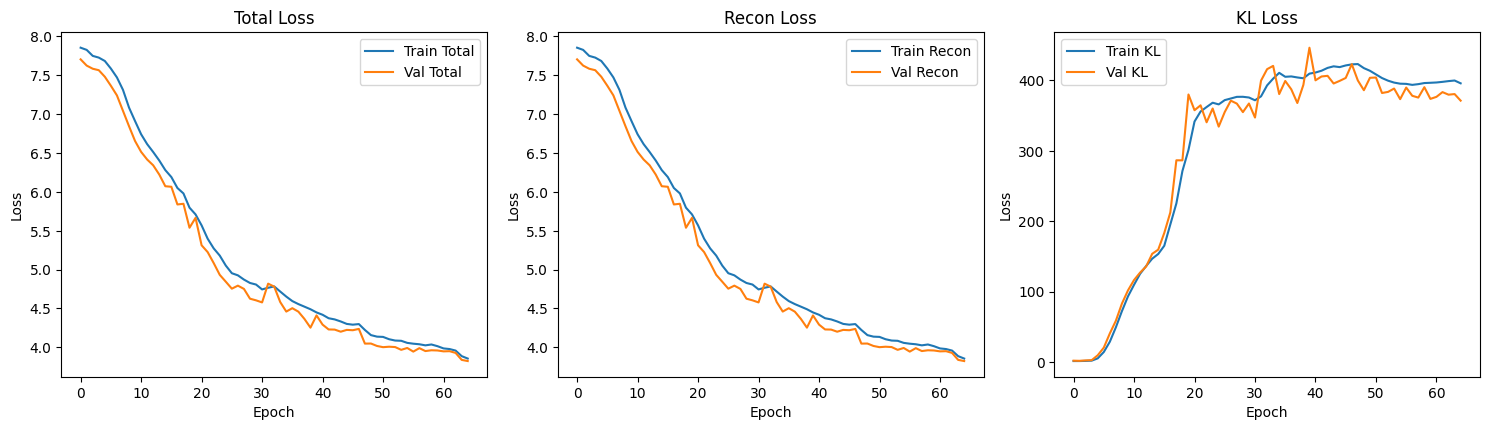

In [ ]:
plot_losses(train_losses, val_losses)

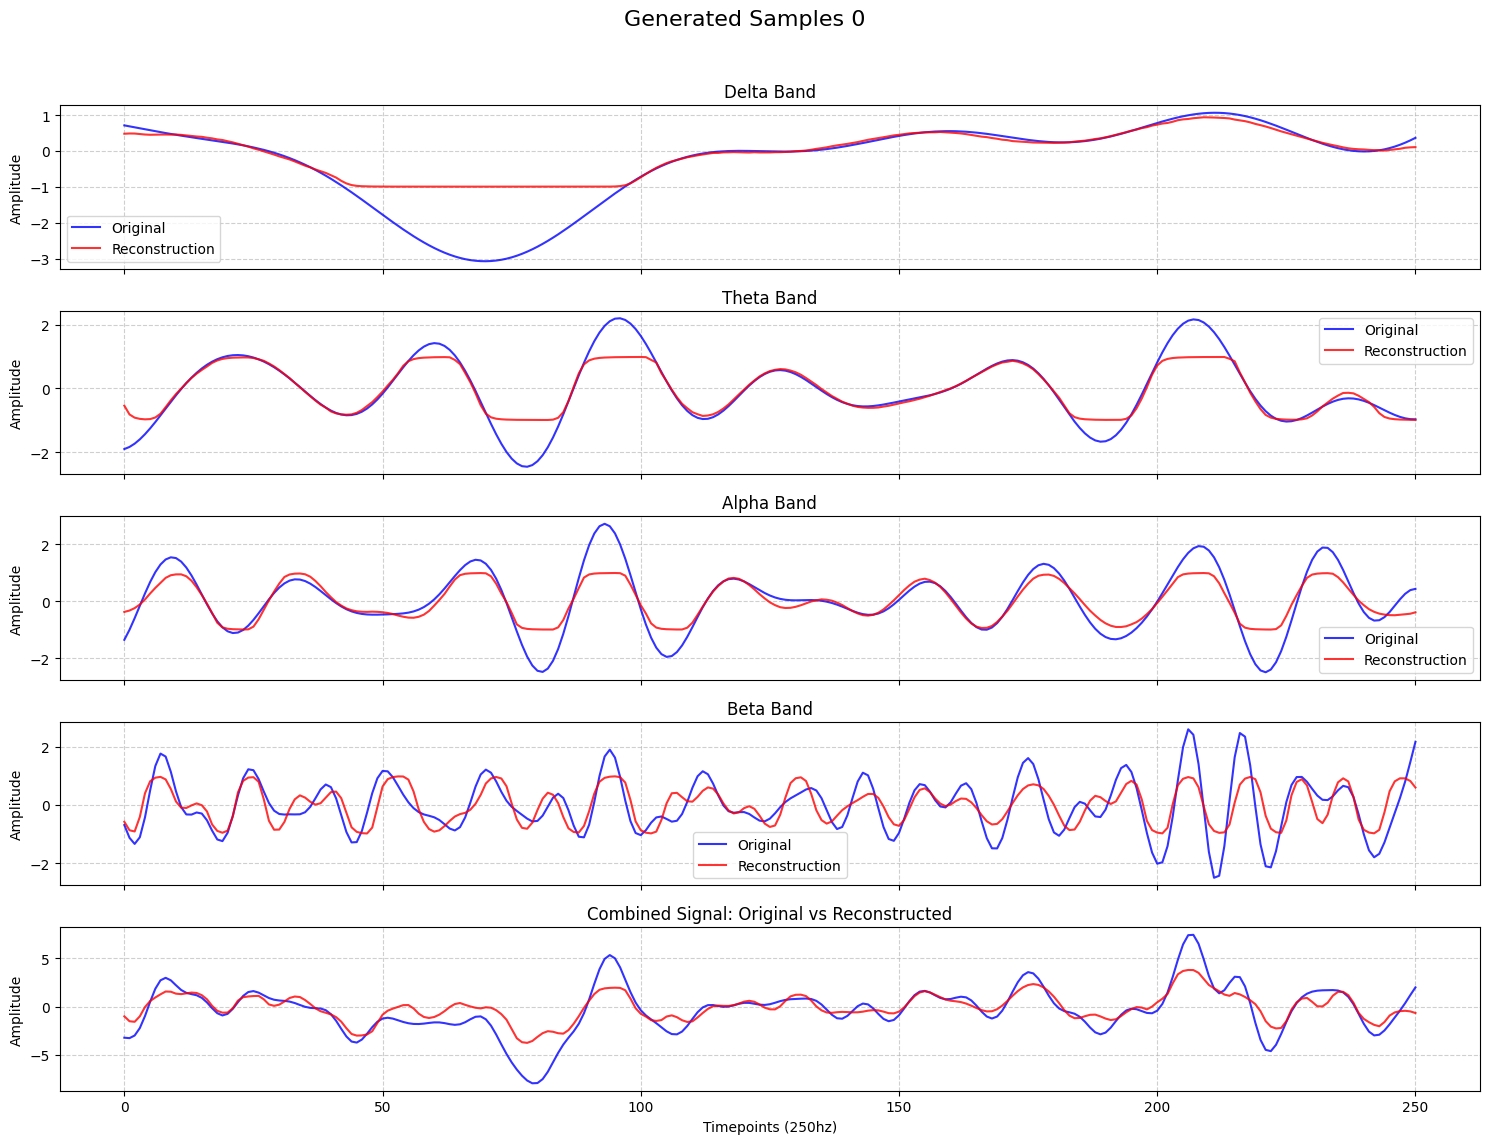

In [ ]:
plot_reconstruction(multiband_model, val_loader)

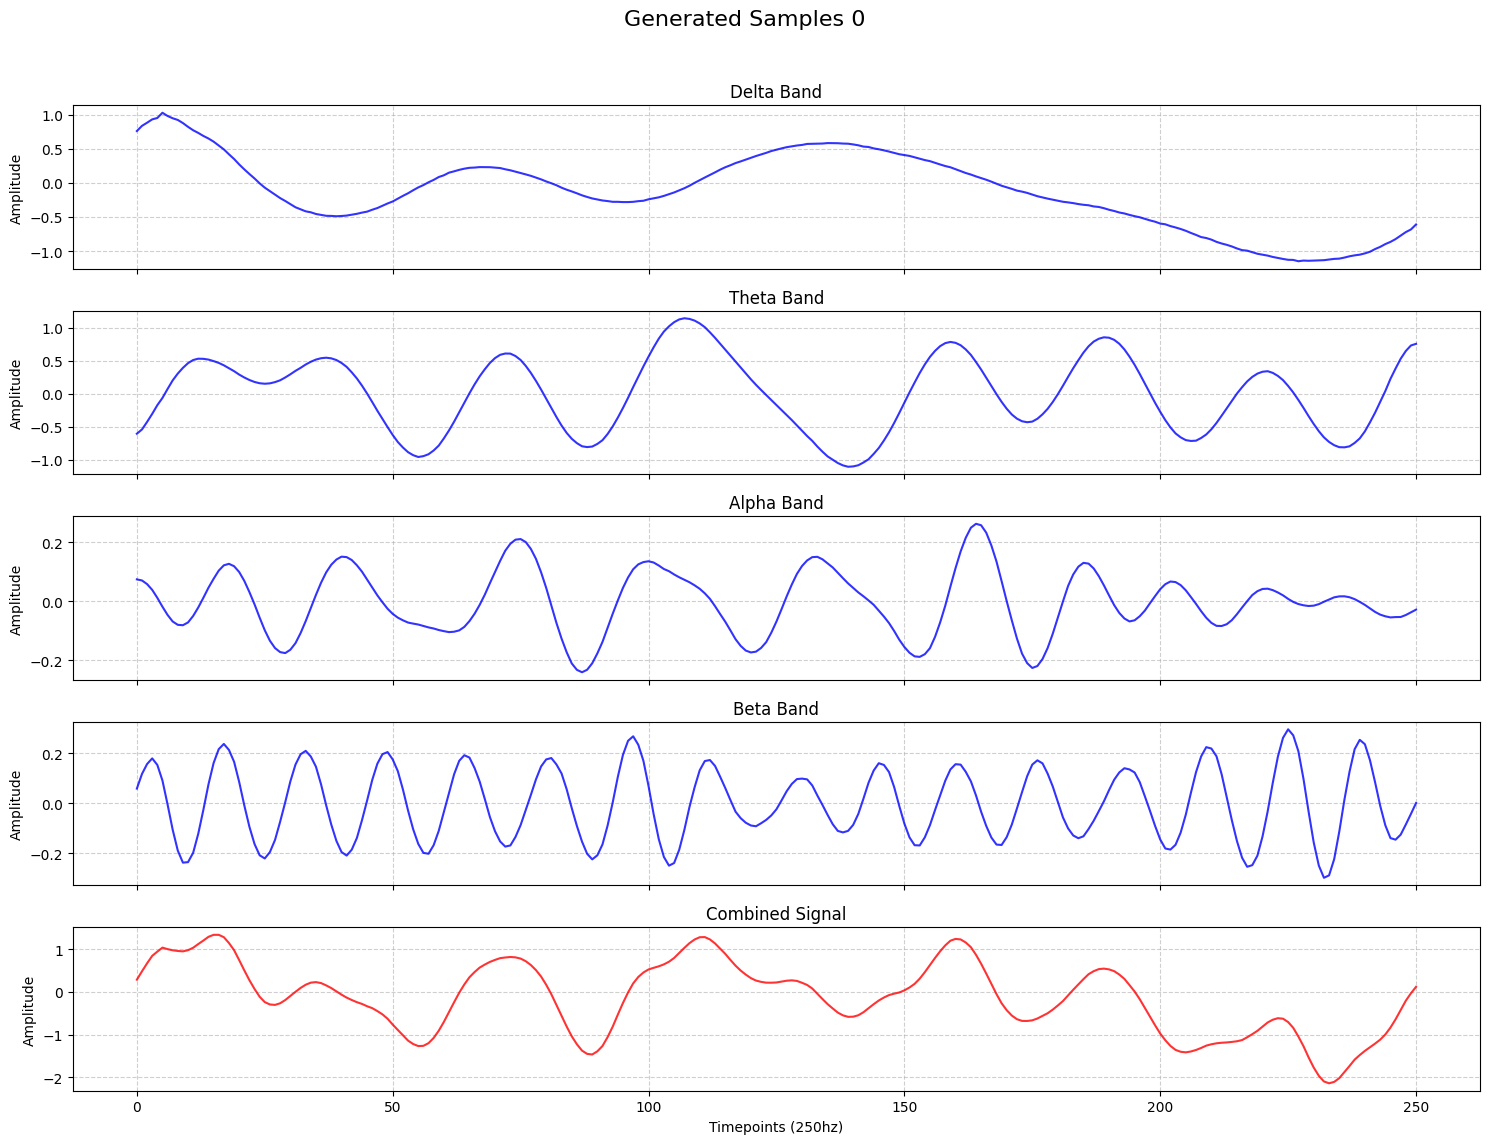

In [ ]:
plot_generation(multiband_model)

In [ ]:
runtime.unassign()

#Multimodal VAE Analysis

**WORK IN PROGRESS**